In [1]:
import os
import sys
import time

#import ariadne.graph_net.model
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_122310/1187170015.py:13: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display
/tmp/ipykernel_122310/1187170015.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
    
from eval.event_evaluation import EventEvaluator
from ariadne_v2.transformations import Compose, DropShort, DropTracksWithHoles, DropSpinningTracks, BakeStationValues, ConstraintsNormalize, FixStationsBMN, ToCylindrical
from ariadne.utils.model import get_checkpoint_path, weights_update

In [4]:
from ariadne.utils.timer import CudaTimer

In [5]:
import scripts.clean_cache

#to clean cache if needed
#scripts.clean_cache.clean_jit_cache('20w')

## Tracknet

In [37]:
import torch
#torch.set_num_threads(1)
#torch.autograd.set_detect_anomaly(False)

import faiss
import onnxruntime as ort
#ort.set_default_logger_severity(0)

NUM_POINTS_TO_SEARCH = 1

from ariadne_v2.inference import IModelLoader
from ariadne.tracknet_v2.model import TrackNETv2
class TrackNetModelLoader(IModelLoader):    
    def __call__(self):
        
        #tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne_spd/ariadne/lightning_logs/TrackNETMissingHits',
        tracknet_ckpt_path_dict = {'model_dir': '/lustre/home/user/d/drusov/ariadne_unzipped/ariadne_spd/ariadne/lightning_logs/TrackNETMissingHits',
                                   'version': 'StepAhead_best', 'checkpoint': 'latest'}#'VirtualPoints_1000ep'
                                   #'version': 'OnlyRNN_alpha0.01_unbalanced', 'checkpoint': 'latest'}
        path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)

        model_tr = weights_update(model=TrackNETInference(),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
        model_tr.eval()
        model_tr = model_tr.to(DEVICE)
        for param in model_tr.parameters():
            param.requires_grad = False
        
        model_tr = torch.jit.script(model_tr).to(DEVICE)
        model_tr = torch.jit.optimize_for_inference(model_tr)
        """
        path_to_tracknet_ckpt = 'torchscript_model.pt'
        model_tr = torch.jit.load(path_to_tracknet_ckpt)
        model_tr.eval()
        """
        """
        torch.onnx.export(model_tr, 
                          dummy_tracks, 
                          "tracknetv3.onnx",
                          export_params=True,
                          opset_version=11,
                          do_constant_folding=True,  # whether to execute constant folding for optimization
                          input_names = ['inputs'],   # the model's input names
                          output_names = ['output'], # the model's output names
                          dynamic_axes={'inputs' : {0 : 'batch_size'},    # variable length axes
                                        'output' : {0 : 'batch_size'}})
        
        so = ort.SessionOptions()
        so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]
        providers = providers if DEVICE == 'cuda' else providers[1:]
        model_tr = ort.InferenceSession('tracknetv3.onnx', sess_options=so, providers=providers)
        """
        model_hash = {
            "tracknet_ckpt_path_dict":path_to_tracknet_ckpt,
            'gin':gin.config_str(), 
            'model': '%r' % model_tr,
            'NUM_POINTS_TO_SEARCH':NUM_POINTS_TO_SEARCH
        }
        return model_hash, [model_tr]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
import ariadne.transformations as trn

tracknet_transformer = trn.Compose([
    #trn.DropShort(num_stations=4),
    #trn.DropTracksWithHoles(),
    #trn.DropSpinningTracks(),
    #trn.BakeStationValues(values=z_values),
    #trn.ConstraintsNormalize(constraints=constraints),
    #trn.ToCylindrical()
    ]
)

def preprocess_one_event(event_df):
    try:
        tracknet_data = tracknet_transformer(event_df)
    except AssertionError as err:
        #print("ASS error %r" % err)
        return None
    numpy_data = parse_df(tracknet_data)
    return ((numpy_data, tracknet_data), 1)

times = []

res_1 = None

from ariadne.graph_net.dataset import collate_fn

def run_tracknet_eval(result_from_prev_step, model, n_neighbours=NUM_POINTS_TO_SEARCH):
    numpy_data, event_df = result_from_prev_step[0]
    preds = run_model(numpy_data, model)
        
    #ev_first, ev_drop1, ev_drop2, ev_model1, ev_model2, ev_search2, ev_filter2, ev_prolong2, ev_last, ev_dropd_1, ev_dropd_2 = cuda_events
    #torch.cuda.synchronize()
    #times['total'].append(ev_first.elapsed_time(ev_last))
    #try:
    #    times['drop'].append(ev_drop1.elapsed_time(ev_drop2))
    #except:
    #    pass    
    #try:
    #    times['dropd'].append(ev_dropd_1.elapsed_time(ev_dropd_2))
    #except:
    #    pass
    #for i in range(34):
    #    try:
    #        times['model'].append(ev_model1[i].elapsed_time(ev_model2[i]))
    #    except:
    #        break
    #    times['search'].append(ev_model2[i].elapsed_time(ev_search2[i]))
    #    times['filter'].append(ev_search2[i].elapsed_time(ev_filter2[i]))
    #    times['prolong'].append(ev_filter2[i].elapsed_time(ev_prolong2[i]))
    
    result = build_df(preds, event_df)
    for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
        result[col] = result[col].astype(int)
    #res_1.append(result)
    return result

@CudaTimer.timeit(name='event')
def run_model(numpy_data, model):
    with torch.no_grad():
        inputs = setup(*numpy_data)
        #res_1.append(inputs)
        preds = model[0](*inputs)
    return preds

cuda


In [7]:
from typing import List

In [8]:
N_STATIONS = 35
COLS = ['x', 'y', 'z']

# GLOBAL

def get_seeds_only_first_station(df, columns=['x','y','z']):
    real = df
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    
    seeds = torch.zeros((len(temp1), N_STATIONS, 3), dtype=torch.float32, device=DEVICE)
    #seeds = np.zeros((len(temp1), N_STATIONS, 3))
    seeds[:, 0, :] = torch.from_numpy(st0_hits)
    return seeds

def get_first_station_hits(df, columns=['x','y','z']):
    real = df
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    return st0_hits

def build_hits(target_df, cols = ['x', 'y', 'z']):
    cont = torch.from_numpy(target_df[cols].values).contiguous().to(torch.float32).to(DEVICE)
    return cont

def parse_df(df, cols = ['x', 'y', 'z']):
    first_hits = get_first_station_hits(df)
    first_indexes = df[df.station == 0].index_old.values
    
    global_indexes = df.index_old.values
    global_hits = df[cols].values.astype('float32')
    
    #hits_by_station = []
    #indexes_by_station = []
    #for station in range(N_STATIONS):
    #    station_df = df.query('station == @station or station == @station + 1')
    #    hits_by_station.append(station_df[['x', 'y', 'z']].values.astype('float32'))
    #    indexes_by_station.append(station_df.index_old.values)
    return first_hits, first_indexes, global_hits, global_indexes
    #return first_hits, first_indexes, hits_by_station, indexes_by_station

#@CudaTimer.timeit(name='setup')
def setup(first_hits, first_indexes, global_hits, global_indexes):
#def setup(first_hits, first_indexes, hits_by_station, indexes_by_station):
    chunk_data_x = torch.zeros((len(first_hits), N_STATIONS, 3), dtype=torch.float32, device=DEVICE)
    chunk_data_x[:, 0, :3] = torch.from_numpy(first_hits)
    #r_axis = torch.sqrt(chunk_data_x[:, 0, 0]**2 + chunk_data_x[:, 0, 1]**2) + 0.02
    #chunk_data_x[:, 0, 3] = r_axis
    
    chunk_data_len = torch.tensor(np.full(len(chunk_data_x), 1), dtype=torch.int64)
    cand_mask = torch.ones(len(chunk_data_x), dtype=torch.int64, device=DEVICE)
    hits_indexes_global = torch.full((len(chunk_data_x), 35), -1, dtype=torch.int64, device=DEVICE)
    hits_indexes_global[:, 0] = torch.from_numpy(first_indexes)
    
    global_hits = torch.from_numpy(global_hits).to(DEVICE)
    global_indexes = torch.from_numpy(global_indexes).to(DEVICE)
    
    #hits_by_station = [torch.from_numpy(hits).to(DEVICE) for hits in hits_by_station]
    #hits_by_station.append(torch.empty((1, 3), device=DEVICE))
    #indexes_by_station = [torch.from_numpy(indexes).to(DEVICE) for indexes in indexes_by_station]
    #indexes_by_station.append(torch.empty((1), device=DEVICE, dtype=torch.long))
    return chunk_data_x, cand_mask, hits_indexes_global, global_indexes, global_hits
    #return chunk_data_x, cand_mask, hits_indexes_global, hits_by_station, indexes_by_station

def build_df(indexes, event_df):
    #preds, indexes = preds
    new_columns = [*[f'hit_id_{i}' for i in range(N_STATIONS)], 'event', 'track_pred']
    if len(indexes) == 0:
        return pd.DataFrame(columns=new_columns).astype(float)
    indexes = indexes.cpu().numpy()
    #res_1.append(preds)
    curr_event = event_df.event.values[0]
    
    """
    big_index = build_index(event_df)
    event_idxs = np.array(event_df.index_old)
    tracks_list = []
    max_index = event_df.index.max()
    """
    
    #res_df = pd.DataFrame(columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    #res_df = pd.DataFrame(data=np.full_like(indexes, -1), columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    res_df = pd.DataFrame(data=indexes, columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    res_df['event'] = curr_event
    res_df['track_pred'] = True
    res_df['track_pred'] = res_df['track_pred'].astype(bool)
    #res_1.append(res_df.copy())
    
    #event_df.set_index(event_df.index_old, inplace=True)
    #for idx, track_hits in enumerate(indexes):
    #    track_hits = track_hits[track_hits > -1]
    #    stations, indices = np.unique(event_df.loc[track_hits].station.values, return_index=True)
    #    track_hits = track_hits[indices]
    #    try:
    #        res_df.loc[idx, [f'hit_id_{st}' for st in stations]] = track_hits
    #    except:
    #        res_df.drop(idx, inplace=True)
    #res_df = res_df.fillna(-1)
    """
    res_df = pd.DataFrame({'event': [curr_event] * len(preds),
                           'track_pred': np.ones(len(preds))#.astype(bool),
                          })
    for i in range(N_STATIONS):
        res_df[f'hit_id_{i}'] = indexes[:, i].numpy().astype(int)
    #res_df.track_pred = res_df.track_pred.astype('bool')
    #print(res_df)"""
    #res_1.append(res_df.copy())
    return res_df


In [9]:
# BY STATION

def get_seeds_only_first_station(df, columns=['x','y','z']):
    real = df
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    
    seeds = torch.zeros((len(temp1), N_STATIONS, 3), dtype=torch.float32, device=DEVICE)
    #seeds = np.zeros((len(temp1), N_STATIONS, 3))
    seeds[:, 0, :] = torch.from_numpy(st0_hits)
    return seeds

def get_first_station_hits(df, columns=['x','y','z']):
    real = df
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    return st0_hits

def build_hits(target_df, cols = ['x', 'y', 'z']):
    cont = torch.from_numpy(target_df[cols].values).contiguous().to(torch.float32).to(DEVICE)
    return cont

def parse_df(df, cols = ['x', 'y', 'z']):
    first_hits = get_first_station_hits(df)
    first_indexes = df[df.station == 0].index_old.values
    
    #global_indexes = df.index_old.values
    #global_hits = df[cols].values.astype('float32')
    
    hits_by_station = []
    indexes_by_station = []
    for station in range(N_STATIONS):
        station_df = df.query('station == @station or station == @station + 1')
        hits_by_station.append(station_df[['x', 'y', 'z']].values.astype('float32'))
        indexes_by_station.append(station_df.index_old.values)
    #return first_hits, first_indexes, global_hits, global_indexes
    return first_hits, first_indexes, hits_by_station, indexes_by_station

#@CudaTimer.timeit(name='setup')
#def setup(first_hits, first_indexes, global_hits, global_indexes):
def setup(first_hits, first_indexes, hits_by_station, indexes_by_station):
    chunk_data_x = torch.zeros((len(first_hits), N_STATIONS, 3), dtype=torch.float32, device=DEVICE)
    chunk_data_x[:, 0, :3] = torch.from_numpy(first_hits)
    #r_axis = torch.sqrt(chunk_data_x[:, 0, 0]**2 + chunk_data_x[:, 0, 1]**2) + 0.02
    #chunk_data_x[:, 0, 3] = r_axis
    
    chunk_data_len = torch.tensor(np.full(len(chunk_data_x), 1), dtype=torch.int64)
    cand_mask = torch.ones(len(chunk_data_x), dtype=torch.int64, device=DEVICE)
    hits_indexes_global = torch.full((len(chunk_data_x), 35), -1, dtype=torch.int64, device=DEVICE)
    hits_indexes_global[:, 0] = torch.from_numpy(first_indexes)
    
    #global_hits = torch.from_numpy(global_hits).to(DEVICE)
    #global_indexes = torch.from_numpy(global_indexes).to(DEVICE)
    
    hits_by_station = [torch.from_numpy(hits).to(DEVICE) for hits in hits_by_station]
    #hits_by_station.append(torch.empty((1, 3), device=DEVICE))
    indexes_by_station = [torch.from_numpy(indexes).to(DEVICE) for indexes in indexes_by_station]
    #indexes_by_station.append(torch.empty((1), device=DEVICE, dtype=torch.long))
    #return chunk_data_x, cand_mask, hits_indexes_global, global_indexes, global_hits
    return chunk_data_x, cand_mask, hits_indexes_global, hits_by_station, indexes_by_station

def build_df(indexes, event_df):
    #preds, indexes = preds
    new_columns = [*[f'hit_id_{i}' for i in range(N_STATIONS)], 'event', 'track_pred']
    if len(indexes) == 0:
        return pd.DataFrame(columns=new_columns).astype(float)
    indexes = indexes.cpu().numpy()
    #res_1.append(preds)
    curr_event = event_df.event.values[0]
    
    """
    big_index = build_index(event_df)
    event_idxs = np.array(event_df.index_old)
    tracks_list = []
    max_index = event_df.index.max()
    """
    
    #res_df = pd.DataFrame(columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    #res_df = pd.DataFrame(data=np.full_like(indexes, -1), columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    res_df = pd.DataFrame(data=indexes, columns=[f'hit_id_{i}' for i in range(N_STATIONS)])
    res_df['event'] = curr_event
    res_df['track_pred'] = True
    res_df['track_pred'] = res_df['track_pred'].astype(bool)
    #res_1.append(res_df.copy())
    
    #event_df.set_index(event_df.index_old, inplace=True)
    #for idx, track_hits in enumerate(indexes):
    #    track_hits = track_hits[track_hits > -1]
    #    stations, indices = np.unique(event_df.loc[track_hits].station.values, return_index=True)
    #    track_hits = track_hits[indices]
    #    try:
    #        res_df.loc[idx, [f'hit_id_{st}' for st in stations]] = track_hits
    #    except:
    #        res_df.drop(idx, inplace=True)
    #res_df = res_df.fillna(-1)
    """
    res_df = pd.DataFrame({'event': [curr_event] * len(preds),
                           'track_pred': np.ones(len(preds))#.astype(bool),
                          })
    for i in range(N_STATIONS):
        res_df[f'hit_id_{i}'] = indexes[:, i].numpy().astype(int)
    #res_df.track_pred = res_df.track_pred.astype('bool')
    #print(res_df)"""
    #res_1.append(res_df.copy())
    return res_df


class TrackNETInference(torch.nn.Module):
    def __init__(self):
        super().__init__()
        input_features = 4
        hidden_features = 32
        output_features = 3
        batch_first = True
        self.rnn = torch.nn.GRU(
            input_size=input_features,
            hidden_size=hidden_features,
            num_layers=2,
            batch_first=batch_first
        )
        
        self.coords_1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, output_features)
        )
        self.radius_1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, 1),
            torch.nn.Softplus()
        )
        self.coords_2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, output_features)
        )
        self.radius_2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, 1),
            torch.nn.Softplus()
        )
        
    #def forward(self, chunk_data_x, cand_mask, hits_indexes_global, hits_by_station: List[torch.Tensor], indexes_by_station: List[torch.Tensor]):
    #@CudaTimer.timeit(name='event')
    def forward(self, chunk_data_x, cand_mask, hits_indexes_global, global_indexes, global_hits):
        # type: (Tensor, Tensor, Tensor, Tensor, Tensor) -> Tensor
        #timer.start('event')
        max_n_stations = 35

        for stations_gone in range(1, max_n_stations):
            #if stations_gone == 2:
            #    ev_dropd_1.record(stream)
            #timer.start('drop_duplicated')
            cand_mask, chunk_data_x, hits_indexes_global = self.drop_duplicated(cand_mask, chunk_data_x, hits_indexes_global, stations_gone)
            #timer.end('drop_duplicated')
            #    ev_dropd_2.record(stream)
            
            if stations_gone == 4:
                #timer.start('drop_short')
                cand_mask, chunk_data_x, hits_indexes_global = self.drop_short(cand_mask, chunk_data_x, hits_indexes_global)
                #timer.end('drop_short')
            #if len(hits_by_station[stations_gone]) == 0:
            #    break

            #timer.start('exec_model')
            prediction = self.exec_model(chunk_data_x, stations_gone)
            #timer.end('exec_model')
            #timer.start('search_torchdist')
            distances, nearest_hits, hits_indexes = self.search_torchdist(prediction[:, :4], global_hits, global_indexes)
            #timer.end('search_torchdist')
            #distances, nearest_hits, hits_indexes = self.search_torchdist(single_prediction, hits_by_station[stations_gone], indexes_by_station[stations_gone])
            #timer.start('filter')
            in_ellipse_mask = self.filter_hits_by_distance(prediction, distances)
            #timer.end('filter')
            
            not_ellipse_mask = ~in_ellipse_mask.to(torch.bool)
            #timer.start('second_search')
            distances2, nearest_hits2, hits_indexes2 = self.search_torchdist(prediction[not_ellipse_mask, 4:], global_hits, global_indexes)
            #timer.end('second_search')
            #timer.start('second_filter')
            in_ellipse_mask2 = self.filter_hits_by_distance(prediction[not_ellipse_mask, 4:], distances2)
            nearest_hits[not_ellipse_mask] = nearest_hits2
            hits_indexes[not_ellipse_mask] = hits_indexes2
            in_ellipse_mask[not_ellipse_mask] += in_ellipse_mask2
            #timer.end('second_filter')
            #print(in_ellipse_mask2)
            #timer.start('prolong')
            chunk_data_x, hits_indexes_global, cand_mask = self.prolong(in_ellipse_mask, chunk_data_x, stations_gone, nearest_hits, hits_indexes_global, hits_indexes, cand_mask)
            #timer.end('prolong')
        #timer.end('event')
        last_mask = hits_indexes_global[:, -2] == hits_indexes_global[:, -1]
        hits_indexes_global[last_mask, -1] = -1
        #res_1.append(chunk_data_x)
        return hits_indexes_global
    
    @CudaTimer.timeit(name='exec_model')
    def exec_model(self, inputs, stations_gone: int):
        x = inputs
        x, _ = self.rnn(x)
        coords_1 = self.coords_1(x)
        radius_1 = self.radius_1(x)
        coords_2 = self.coords_2(x)
        radius_2 = self.radius_2(x)
        outputs = torch.cat([coords_1, radius_1, coords_2, radius_2], dim=-1)
        #outputs = torch.cat([coords_1, radius_1], dim=-1)
        single_prediction = outputs[:, stations_gone - 1]
        #if printing:
        #    print(outputs)
        return single_prediction
    
    @CudaTimer.timeit(name='drop_short')
    def drop_short(self, cand_mask, chunk_data_x, hits_indexes_global):
        mask = cand_mask.to(torch.bool)
        chunk_data_x = chunk_data_x[mask].contiguous()
        hits_indexes_global = hits_indexes_global[mask]
        cand_mask = cand_mask[mask]
        return cand_mask, chunk_data_x, hits_indexes_global
    
    @CudaTimer.timeit(name='drop_duplicated')
    def drop_duplicated(self, cand_mask, chunk_data_x, hits_indexes_global, stations_gone: int):
        duplicated = hits_indexes_global[:, stations_gone - 2] != hits_indexes_global[:, stations_gone - 1]
        chunk_data_x = chunk_data_x[duplicated].contiguous()
        hits_indexes_global = hits_indexes_global[duplicated]
        cand_mask = cand_mask[duplicated]
        return cand_mask, chunk_data_x, hits_indexes_global
    
    @CudaTimer.timeit(name='search_torchdist')
    def search_torchdist(self, centers, global_hits, global_indexes):
        centers = centers[:, :3]
        D, I = torch.min(torch.cdist(centers, global_hits, compute_mode='use_mm_for_euclid_dist'), dim=1)
        hits_indexes = global_indexes[I]
        nearest_hits = global_hits[I]
        return D, nearest_hits, hits_indexes
    
    @CudaTimer.timeit(name='filter')
    def filter_hits_by_distance(self, ellipses, distances):
        return (distances.flatten() < ellipses[:, 3]).int()
    
    @CudaTimer.timeit(name='prolong')
    def prolong(self, in_ellipse_mask, chunk_data_x, stations_gone: int, nearest_hits, hits_indexes_global, hits_indexes, cand_mask):
        cand_mask = in_ellipse_mask * cand_mask
        chunk_data_x[:, stations_gone, :3] = nearest_hits * cand_mask.reshape(-1, 1)
        r_axis = torch.sqrt(chunk_data_x[:, :, 0]**2 + chunk_data_x[:, :, 1]**2) + 0.02
        chunk_data_x[:, :, 3] = r_axis
        hits_indexes_global[:, stations_gone] = hits_indexes * cand_mask + cand_mask - 1
        return chunk_data_x, hits_indexes_global, cand_mask

In [10]:
    #def forward(self, chunk_data_x, cand_mask, hits_indexes_global, global_indexes, global_hits):
        # type: (Tensor, Tensor, Tensor, Tensor, Tensor) -> Tensor
        
        
    #def forward(self, chunk_data_x, cand_mask, hits_indexes_global, hits_by_station: List[torch.Tensor], indexes_by_station: List[torch.Tensor]):


In [11]:
class TrackNETInference(torch.nn.Module):
    def __init__(self):
        super().__init__()
        input_features = 3
        hidden_features = 32
        output_features = 3
        batch_first = True
        self.rnn = torch.nn.GRU(
            input_size=input_features,
            hidden_size=hidden_features,
            num_layers=2,
            batch_first=batch_first
        )
        
        self.coords_1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, output_features)
        )
        self.radius_1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, 1),
            torch.nn.Softplus()
        )
        self.coords_2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, output_features)
        )
        self.radius_2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, 1),
            torch.nn.Softplus()
        )
        
    #@CudaTimer.timeit(name='event')
    def forward(self, chunk_data_x, cand_mask, hits_indexes_global, hits_by_station: List[torch.Tensor], indexes_by_station: List[torch.Tensor]):
        chunk_data_x = chunk_data_x.clone()
        cand_mask = cand_mask.clone()
        hits_indexes_global = hits_indexes_global.clone()
        max_n_stations = 35
        
        prediction = self.exec_model(chunk_data_x, 1)
        first_dists, second_dists, first_nearest_hits, second_nearest_hits, first_hits_indexes, second_hits_indexes = self.search_both(prediction, hits_by_station[1], indexes_by_station[1])
        in_ellipse_mask1 = self.filter_hits_by_distance(prediction, first_dists)
        in_ellipse_mask2 = self.filter_hits_by_distance(prediction[:, 4:], second_dists)
            
        saved_mask = (in_ellipse_mask1 == 0) * (in_ellipse_mask2 == 1)
        saved_hits = second_nearest_hits
        saved_indexes = second_hits_indexes
        
        chunk_data_x, hits_indexes_global, cand_mask = self.prolong(in_ellipse_mask1, in_ellipse_mask2, chunk_data_x, 1, first_nearest_hits, prediction[:, :3], hits_indexes_global, first_hits_indexes, second_hits_indexes, cand_mask)
        
        prediction = self.exec_model(chunk_data_x, 2)
        first_dists, second_dists, first_nearest_hits, second_nearest_hits, first_hits_indexes, second_hits_indexes = self.search_both(prediction, hits_by_station[2], indexes_by_station[2])
        in_ellipse_mask1 = self.filter_hits_by_distance(prediction, first_dists)
        in_ellipse_mask2 = self.filter_hits_by_distance(prediction[:, 4:], second_dists)
        chunk_data_x, hits_indexes_global, cand_mask = self.prolong(in_ellipse_mask1, in_ellipse_mask2, chunk_data_x, 2, first_nearest_hits, prediction[:, :3], hits_indexes_global, first_hits_indexes, second_hits_indexes, cand_mask)
        
        chunk_data_x[:, 2, :3][saved_mask] = saved_hits[saved_mask]
        hits_indexes_global[:, 2][saved_mask] = saved_indexes[saved_mask]
        cand_mask[saved_mask] = 1
        
        for stations_gone in range(3, max_n_stations):
            #if len(indexes_by_station[stations_gone + 1]) == 0:
            #    return hits_indexes_global
            #if len(indexes_by_station[stations_gone]) == 0:
            #    return hits_indexes_global
            
            if stations_gone == 5:
                cand_mask, chunk_data_x, hits_indexes_global = self.drop_short(cand_mask, chunk_data_x, hits_indexes_global)
            prediction = self.exec_model(chunk_data_x, stations_gone)
            
            #first_dists, second_dists, first_nearest_hits, second_nearest_hits, first_hits_indexes, second_hits_indexes = self.search_both(prediction, global_hits, global_indexes)
            first_dists, second_dists, first_nearest_hits, second_nearest_hits, first_hits_indexes, second_hits_indexes = self.search_both(prediction, hits_by_station[stations_gone], indexes_by_station[stations_gone])
            #first_dists, first_nearest_hits, first_hits_indexes= self.search_single(prediction, hits_by_station[stations_gone], indexes_by_station[stations_gone])
            #second_dists, second_nearest_hits, second_hits_indexes = self.search_single(prediction[:, 4:], hits_by_station[stations_gone + 1], indexes_by_station[stations_gone + 1])
            
            in_ellipse_mask1 = self.filter_hits_by_distance(prediction, first_dists)
            in_ellipse_mask2 = self.filter_hits_by_distance(prediction[:, 4:], second_dists)
            
            #second_nearest_hits = prediction[:, :3]
            #second_hits_indexes[:] = -1
            
            chunk_data_x, hits_indexes_global, cand_mask = self.prolong(in_ellipse_mask1, in_ellipse_mask2, chunk_data_x, stations_gone, first_nearest_hits, prediction[:, :3], hits_indexes_global, first_hits_indexes, second_hits_indexes, cand_mask)
            
            #cand_mask, chunk_data_x, hits_indexes_global = self.drop_duplicated(cand_mask, chunk_data_x, hits_indexes_global, stations_gone)
            
        #last_mask = hits_indexes_global[:, -2] == hits_indexes_global[:, -1]
        #hits_indexes_global[last_mask, -1] = -1
        #res_1.append(chunk_data_x)
        #res_1.append(hits_indexes_global)
        #res_2.append(chunk_data_x)
        return hits_indexes_global
    
    #@CudaTimer.timeit(name='exec_model')
    def exec_model(self, inputs, stations_gone: int):
        x = inputs
        x, _ = self.rnn(x)
        coords_1 = self.coords_1(x)
        radius_1 = self.radius_1(x)
        coords_2 = self.coords_2(x)
        radius_2 = self.radius_2(x)
        outputs = torch.cat([coords_1, radius_1, coords_2, radius_2], dim=-1)
        #outputs = torch.cat([coords_1, radius_1], dim=-1)
        single_prediction = outputs[:, stations_gone - 1]
        #if printing:
        #    print(outputs)
        return single_prediction
    
    #@CudaTimer.timeit(name='drop_short')
    def drop_short(self, cand_mask, chunk_data_x, hits_indexes_global):
        mask = cand_mask.to(torch.bool)
        chunk_data_x = chunk_data_x[mask].contiguous()
        hits_indexes_global = hits_indexes_global[mask]
        cand_mask = cand_mask[mask]
        return cand_mask, chunk_data_x, hits_indexes_global
    
    #@CudaTimer.timeit(name='drop_duplicated')
    def drop_duplicated(self, cand_mask, chunk_data_x, hits_indexes_global, stations_gone: int):
        duplicated = torch.logical_or(hits_indexes_global[:, stations_gone - 2] != hits_indexes_global[:, stations_gone - 1], hits_indexes_global[:, stations_gone - 1] == -1)
        chunk_data_x = chunk_data_x[duplicated].contiguous()
        hits_indexes_global = hits_indexes_global[duplicated]
        cand_mask = cand_mask[duplicated]
        return cand_mask, chunk_data_x, hits_indexes_global
    
    #@CudaTimer.timeit(name='search_torchdist')
    def search_torchdist(self, centers, global_hits, global_indexes):
        centers = centers[:, :3]
        D, I = torch.min(torch.cdist(centers, global_hits, compute_mode='use_mm_for_euclid_dist'), dim=1)
        hits_indexes = global_indexes[I]
        nearest_hits = global_hits[I]
        return D, nearest_hits, hits_indexes
    
    #@CudaTimer.timeit(name='filter')
    def filter_hits_by_distance(self, ellipses, distances):
        return (distances.flatten() < ellipses[:, 3]).int()

    #@CudaTimer.timeit(name='prolong')
    def prolong(self, in_ellipse_mask1, in_ellipse_mask2, chunk_data_x, stations_gone: int, first_nearest_hits, second_nearest_hits, hits_indexes_global, first_hits_indexes, second_hits_indexes, cand_mask):
        not_ellipse_mask = ~in_ellipse_mask1.to(torch.bool)
        first_nearest_hits[not_ellipse_mask] = second_nearest_hits[not_ellipse_mask]
        first_hits_indexes[not_ellipse_mask] = -1#second_hits_indexes[not_ellipse_mask]
        in_ellipse_mask1[not_ellipse_mask] = in_ellipse_mask2[not_ellipse_mask]
        
        cand_mask = in_ellipse_mask1 * cand_mask
        chunk_data_x[:, stations_gone, :3] = first_nearest_hits * cand_mask.reshape(-1, 1)
        #r_axis = torch.sqrt(chunk_data_x[:, :, 0]**2 + chunk_data_x[:, :, 1]**2) + 0.02
        #chunk_data_x[:, :, 3] = r_axis
        hits_indexes_global[:, stations_gone] = first_hits_indexes * cand_mask + cand_mask - 1
        return chunk_data_x, hits_indexes_global, cand_mask
    
    def prolong_single(self, in_ellipse_mask, chunk_data_x, stations_gone: int, nearest_hits, hits_indexes_global, hits_indexes, cand_mask):
        cand_mask = in_ellipse_mask * cand_mask
        chunk_data_x[:, stations_gone, :3] = nearest_hits * cand_mask.reshape(-1, 1)
        hits_indexes_global[:, stations_gone] = hits_indexes * cand_mask + cand_mask - 1
        return chunk_data_x, hits_indexes_global, cand_mask
    
    #@CudaTimer.timeit(name='search_both')
    def search_both(self, centers, global_hits, global_indexes):
        flattened = centers.reshape((-1, 4))
        flattened = flattened[:, :3]
        D, I = torch.min(torch.cdist(flattened, global_hits, compute_mode='use_mm_for_euclid_dist'), dim=1)
        dist = D.flatten().reshape(-1, 2)
        indexes = I.reshape((-1, 2))
        first_indexes = indexes[:, 0]
        second_indexes = indexes[:, 1]
        
        first_hits_indexes = global_indexes[first_indexes]
        first_nearest_hits = global_hits[first_indexes]
        second_hits_indexes = global_indexes[second_indexes]
        second_nearest_hits = global_hits[second_indexes]
        first_dists = dist[:, 0]
        second_dists = dist[:, 1]
        return first_dists, second_dists, first_nearest_hits, second_nearest_hits, first_hits_indexes, second_hits_indexes

    def search_single(self, centers, hits, indexes):
        centers = centers[:, :3]
        D, I = torch.min(torch.cdist(centers, hits, compute_mode='use_mm_for_euclid_dist'), dim=1)
        dists = D.flatten()
        inds = I.flatten()
        
        nearest_hits = hits[inds]
        hits_indexes = indexes[inds]
        return dists, nearest_hits, hits_indexes


In [12]:
import ariadne

In [13]:
from ariadne_v2.transformations import AddVirtualPoints, DropEmptyFirstStation, ToCylindrical, DropFakes, DropOverPhi, CombineEvents

In [14]:
from tqdm import tqdm

In [15]:
STATION_COLUMNS = [f'hit_id_{i}' for i in range(N_STATIONS)]

In [16]:
columns = ['event', 'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'vtxx', 'vtxy', 'vtxz']

In [26]:
parse_cfg = {
    'csv_params' : {
        "sep": '\t',
        "encoding": 'utf-8',
        "names": columns
    },
    #'input_file_mask':f'/zfs/store5.hydra.local/user/d/drusov/ariadne_spd/ariadne/output/spd_tracknet_train_raw/spdsim_test_missinghits01_fakesnsqr.tsv',
    'input_file_mask':f'/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne_unzipped/ariadne_spd/ariadne/output/spd_tracknet_train_raw/spdsim_test_missinghits02_fakesnsqr.tsv',
    'events_quantity': ':'
}

evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=loaded_model)[0]

In [27]:
loaded_model = TrackNetModelLoader()

In [28]:
constraints = {'x': [-851., 851.], 'y': [-851., 851.], 'z': [-2386., 2386.]}

In [29]:
global_transformer = Compose([
    DropShort(num_stations=3),
    DropEmptyFirstStation(),
    #DropTracksWithHoles(),
    #DropSpinningTracks(),
    #ToCylindrical(),
    #BakeStationValues(r_values, col='r'),
    ConstraintsNormalize(constraints=constraints, columns=('x', 'y', 'z')),
    #DropOverPhi(),
    #DropFakes(),
    CombineEvents(combine_n=40),
]
)

In [30]:
gin.enter_interactive_mode()

In [31]:
printing = False

In [38]:
res_1 = []
res_2 = []
times = []

In [39]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=loaded_model)[0]
all_results = evaluator.build_all_tracks()

# COLD START

model = evaluator.loaded_model_state[1][0]
numpy_data = np.load('cold_start_stations.npy', allow_pickle=True)
inputs = setup(*numpy_data)
for i in range(5):
    start_time = time.time()
    preds = model(*inputs)
    #torch.cuda.synchronize()
    print(time.time() - start_time)
#model.save("torchscript_model.pt")
CudaTimer.clear()
model_results = evaluator.run_model(preprocess_one_event, run_tracknet_eval)
start_time = time.time()
results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=1)
end_time = time.time()
print(f'solving took {end_time - start_time} seconds')

read entry a3057314ff7cbdd061c89b1fb363386f hit
[prepare]: started processing a df spdsim_test_missinghits02_fakesnsqr.tsv with 24934298 rows:
read entry 4e8ff5d4106a375ede673c595cc2c6cd hit
[prepare] finished
[prepare] loading your model(s)...
/lustre/home/user/d/drusov/ariadne_unzipped/ariadne_spd/ariadne/lightning_logs/TrackNETMissingHits/StepAhead_best/*.ckpt
[prepare] finished loading your model(s)...
[build_all_tracks] start
read entry f58a30a88038258c2c8e8666ba8e11c7 hit
read entry b553edbd625e8e36face5d026c7144af hit


processed: 588:  94%|█████████▍| 589/625 [06:51<00:25,  1.39it/s]

In [35]:
times = CudaTimer.times

In [36]:
times_np = np.array(times['event'])
print(f'{1000 / times_np.mean()}, *40 = {40000 / times_np.mean()}')

KeyError: 'event'

In [35]:
evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=loaded_model)[0]

read entry 3e35aa672ee0e30b4c5b75b803fa6126 hit
[prepare]: started processing a df spdsim_test_missinghits02_fakesnsqr_200k.tsv with 199797595 rows:
read entry 6e30315e71ad61c0762410a54d3ecb94 hit
[prepare] finished
[prepare] loading your model(s)...
/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne_unzipped/ariadne_spd/ariadne/lightning_logs/TrackNETMissingHits/version_14/*.ckpt
[prepare] finished loading your model(s)...


In [125]:
loaded_model = TrackNetModelLoader()

In [126]:
model = loaded_model()[1][0]

/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne_unzipped/ariadne_spd/ariadne/lightning_logs/TrackNETMissingHits/version_14/*.ckpt


In [127]:
res_1[5][2]

tensor([[     5187,        -1,        -1,  ...,        -1,        -1,
                -1],
        [  5047524,        -1,        -1,  ...,        -1,        -1,
                -1],
        [  5047559,        -1,        -1,  ...,        -1,        -1,
                -1],
        ...,
        [194809912,        -1,        -1,  ...,        -1,        -1,
                -1],
        [194809919,        -1,        -1,  ...,        -1,        -1,
                -1],
        [194809961,        -1,        -1,  ...,        -1,        -1,
                -1]], device='cuda:0')

In [128]:
model(*res_1[5])[12]

tensor([14985474,       -1, 14985475, 14985476, 14985477, 14985478, 14985479,
        14985480, 14985481, 14985482, 14985483, 14985484, 14985485, 14985486,
        14985487, 14985488, 14985489, 14985490, 14985491, 14985492, 14985493,
        14985494, 14985495, 14985496, 14985497, 14985498, 14985499, 14985500,
        14985501, 14985502, 14985503, 14985504, 14985505, 14985506, 14985507],
       device='cuda:0')

In [100]:
events.query('event == 5 and station == 2')

,event,x,y,z,station,track,px,py,pz,vtxx,vtxy,vtxz,index_old
821,5,-0.002874,-0.357479,-0.048529,2,50,-42.408340,-888.096560,-0.989781,9.295636,0.058425,-115.486706,5189
836709,5,-0.234827,-0.269376,0.065183,2,50050,-376.308293,-485.440588,307.741700,-2.830600,-2.289119,2.842376,5047526
836744,5,0.338376,0.114960,0.023157,2,50051,560.181636,153.076975,100.138777,-2.830600,-2.289119,2.842376,5047561
836779,5,-0.352700,0.056504,0.395744,2,50052,-841.292271,98.905673,2621.625429,-2.830600,-2.289119,2.842376,5047596
836809,5,-0.202627,0.294348,-0.022010,2,50053,-359.212891,584.151665,-125.020509,-2.830600,-2.289119,2.842376,5047626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195644980,5,-0.316769,-0.165430,0.874532,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194809742
195645119,5,-0.357189,-0.011211,0.257441,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194809881
195645140,5,-0.115024,0.338348,0.322696,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194809902
195645220,5,-0.254311,0.251069,-0.436054,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194809982


In [27]:
res_2 = []

In [ ]:
14985474

In [28]:
for i in range(10):
    model(*res_1[i])

In [39]:
len(res_2)

10

In [30]:
res_2[0].shape

torch.Size([173, 35, 3])

In [53]:
tracks = res_2[0]
pred = model.exec_model(tracks, 1)
pred

tensor([[ 0.3026,  0.1489,  0.1148,  ...,  0.1578,  0.1189,  0.0145],
        [ 0.3219,  0.1013,  0.1213,  ...,  0.1073,  0.1254,  0.0144],
        [-0.2060, -0.2674,  0.0613,  ..., -0.2835,  0.0629,  0.0144],
        ...,
        [ 0.3362,  0.0283, -0.6143,  ...,  0.0290, -0.6514,  0.0153],
        [-0.2605, -0.2145, -0.0235,  ..., -0.2272, -0.0250,  0.0143],
        [-0.3283,  0.0787, -0.0846,  ...,  0.0833, -0.0871,  0.0147]],
       device='cuda:0')

In [48]:
tracks = res_2[0]
pred = model.exec_model(tracks, 1)
tracks_miss = tracks
tracks_miss[:, 1] = pred[:, :3]
pred = model.exec_model(tracks_miss, 3)

In [55]:
torch.cdist(tracks[:, 1], pred[:, :3]).diagonal() < pred[:, 3]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [54]:
torch.cdist(tracks[:, 2], pred[:, 4:7]).diagonal() < pred[:, 7]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [57]:
pred[-3, :3]

tensor([0.3327, 0.0558, 0.0027], device='cuda:0')

In [58]:
tracks[-3]

tensor([[0.3129, 0.0528, 0.0026],
        [0.3327, 0.0558, 0.0027],
        [0.3528, 0.0590, 0.0027],
        [0.3715, 0.0667, 0.0041],
        [0.0000, 0.0000, 0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, 0.0000, -0.0000],
        [-0.0000, 0.0000, -0.0000],
        [0.0000, 0.0000, -0.0000],
        [0.0000, -0.0000, -0.0000],
        [0.0000, -0.0000, -0.0000],
        [0.0000, 0.0000, -0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, 0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],

In [32]:
res_2[0]

tensor([[[ 2.8458e-01,  1.3991e-01,  1.1118e-01],
         [ 3.0469e-01,  1.4466e-01,  1.1204e-01],
         [ 3.2486e-01,  1.4897e-01,  1.1314e-01],
         ...,
         [ 9.5856e-01,  5.8498e-04,  1.4439e-01],
         [ 9.7878e-01, -1.5448e-02,  1.4563e-01],
         [ 9.9825e-01, -3.2291e-02,  1.4680e-01]],

        [[ 3.0272e-01,  9.5301e-02,  1.1743e-01],
         [ 3.2116e-01,  1.0306e-01,  1.2049e-01],
         [ 3.3956e-01,  1.1101e-01,  1.2359e-01],
         ...,
         [ 8.5237e-01,  4.3898e-01,  2.1763e-01],
         [ 8.6771e-01,  4.5288e-01,  2.2079e-01],
         [ 8.8306e-01,  4.6691e-01,  2.2401e-01]],

        [[-1.9366e-01, -2.5137e-01,  5.9406e-02],
         [-2.0543e-01, -2.6752e-01,  6.0342e-02],
         [-2.1679e-01, -2.8416e-01,  6.1195e-02],
         ...,
         [-5.2580e-01, -8.0169e-01,  8.7797e-02],
         [-5.3486e-01, -8.1968e-01,  8.8709e-02],
         [-5.4378e-01, -8.3782e-01,  8.9529e-02]],

        ...,

        [[ 3.1625e-01,  2.5459e-02, -5

In [85]:
in_ellipse_mask1 = res_2[1][0]

In [86]:
in_ellipse_mask2 = res_2[1][1]

In [87]:
((~in_ellipse_mask1.to(torch.bool) * in_ellipse_mask2).to(torch.bool)).any()

tensor(False, device='cuda:0')

In [88]:
~in_ellipse_mask1.to(torch.bool)

tensor([False, False, False,  ..., False,  True,  True], device='cuda:0')

In [89]:
in_ellipse_mask2.to(torch.bool)

tensor([ True,  True, False,  ...,  True, False, False], device='cuda:0')

In [90]:
~in_ellipse_mask1.to(torch.bool) * in_ellipse_mask2

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [91]:
(~in_ellipse_mask1.to(torch.bool) == in_ellipse_mask2.to(torch.bool))

tensor([False, False,  True,  ..., False, False, False], device='cuda:0')

In [92]:
in_ellipse_mask2[(~in_ellipse_mask1.to(torch.bool) == in_ellipse_mask2.to(torch.bool))]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [93]:
in_ellipse_mask1 != in_ellipse_mask2

tensor([False, False,  True,  ..., False, False, False], device='cuda:0')

In [94]:
((in_ellipse_mask1 == 0) * (in_ellipse_mask2 == 1)).any()

tensor(False, device='cuda:0')

In [95]:
in_ellipse_mask2 == 1

tensor([ True,  True, False,  ...,  True, False, False], device='cuda:0')

In [28]:
evaluator.solve_results(model_results, all_results, match_percentage=1)

[solve results] start
[solve results] finish
[solve results] final stats:
==========EVALUATION RESULTS==========
Total events evaluated: 5000
Total tracks evaluated: 972881
Track Efficiency (recall): 0.9314 
Track Purity (precision): 0.9155 
Fully reconstructed event ratio: 0.0000
Mean cpu time per event: 0.0756 sec (13.23 events per second) 
Mean gpu time per event: 0.0583 sec (17.15 events per second) 
==========EVALUATION RESULTS==========


(         event_id   track          px          py           pz  pred  \
 7               0  150001  825.558497 -357.847046  2090.135001     0   
 24              0  250003  -15.743881 -309.851992    27.070562     0   
 47              0  500005    1.039465  522.152986  1370.668520     0   
 56              0  550006   97.511662   26.571055    48.285084     0   
 70              0  750003 -584.761124  212.362564  -236.081772     0   
 ...           ...     ...         ...         ...          ...   ...   
 1056569      4999      -1         NaN         NaN          NaN    -1   
 1056570      4999      -1         NaN         NaN          NaN    -1   
 1056571      4999      -1         NaN         NaN          NaN    -1   
 1056572      4999      -1         NaN         NaN          NaN    -1   
 1056573      4999      -1         NaN         NaN          NaN    -1   
 
           hit_id_0   hit_id_1   hit_id_2   hit_id_3  ...  hit_id_25  \
 7         14981862   14981863         -1   149818

[solve results] start
[solve results] finish
[solve results] final stats:
==========EVALUATION RESULTS==========
Total events evaluated: 24959
Total tracks evaluated: 123075
Track Efficiency (recall): 0.9789 
Track Purity (precision): 0.9907 
Fully reconstructed event ratio: 0.9032
Mean cpu time per event: 0.0025 sec (407.12 events per second) 
Mean gpu time per event: 0.0430 sec (23.25 events per second) 
==========EVALUATION RESULTS==========


In [28]:
times['event'] = np.array(times['event'])
times['setup'] = np.array(times['setup'])
times['drop_short'] = np.array(times['drop_short'])
times['exec_model'] = np.array(times['exec_model'])
times['filter'] = np.array(times['filter'])
times['search_both'] = np.array(times['search_both'])
times['prolong'] = np.array(times['prolong'])
times['drop_duplicated'] = np.array(times['drop_duplicated'])
#times['second_search'] = np.array(times['second_search'])
#times['second_filter'] = np.array(times['second_filter'])

for key in times.keys():
    print(f'{key} time: {times[key].sum():.2f} ms, mean {times[key].mean():.2f} ms, ratio {times[key].sum() / times["event"].sum():.2f}')
print()
#print(f'Total time: {times["event"].sum():.2f} ms, mean {times["event"].mean():.2f} ms, timeslices per sec {40000 / times["event"].mean():.2f}')

KeyError: 'setup'

In [41]:
len(res_1)

50000

In [ ]:
res_1 = res_1[5:]

In [43]:
res_1[13]

tensor([[6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648,
         6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660,
         6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671],
        [6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683,
         6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695,
         6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703,   -1, 6705,   -1],
        [6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717,
         6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729,
         6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740],
        [6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752,
         6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764,
         6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775]],
       device='cuda:0')

In [ ]:
events.query('event == 6 and track == 2')

,event,x,y,z,station,track,px,py,pz,vtxx,vtxy,vtxz,index_old
1011,6,0.100980,-0.300961,-0.018931,0,2,309.187502,-821.834288,-985.724714,-3.529131,20.800146,258.096094,6672
1012,6,0.108192,-0.319403,-0.026910,1,2,312.891028,-820.431419,-985.724714,-3.529131,20.800146,258.096094,6673
1013,6,0.115367,-0.338177,-0.034951,2,2,316.588505,-819.011738,-985.724714,-3.529131,20.800146,258.096094,6674
1014,6,0.122648,-0.356861,-0.043068,3,2,320.279875,-817.575262,-985.724714,-3.529131,20.800146,258.096094,6675
1015,6,0.130012,-0.375515,-0.050936,4,2,323.965080,-816.122010,-985.724714,-3.529131,20.800146,258.096094,6676
1016,6,0.137409,-0.394288,-0.059068,5,2,327.644062,-814.651997,-985.724714,-3.529131,20.800146,258.096094,6677
1017,6,0.145011,-0.412687,-0.067047,6,2,331.316762,-813.165242,-985.724714,-3.529131,20.800146,258.096094,6678
1018,6,0.152613,-0.431296,-0.075191,7,2,334.983123,-811.661762,-985.724714,-3.529131,20.800146,258.096094,6679
1019,6,0.160211,-0.450118,-0.083184,8,2,338.643086,-810.141573,-985.724714,-3.529131,20.800146,258.096094,6680
1020,6,0.168106,-0.468313,-0.091313,9,2,342.296594,-808.604693,-985.724714,-3.529131,20.800146,258.096094,6681


In [47]:
res_1[12][1]

tensor([[ 0.1010, -0.3010, -0.0189,  0.3375],
        [ 0.1082, -0.3194, -0.0269,  0.3572],
        [ 0.1154, -0.3382, -0.0350,  0.3773],
        [ 0.1226, -0.3569, -0.0431,  0.3973],
        [ 0.1300, -0.3755, -0.0509,  0.4174],
        [ 0.1374, -0.3943, -0.0591,  0.4375],
        [ 0.1450, -0.4127, -0.0670,  0.4574],
        [ 0.1526, -0.4313, -0.0752,  0.4775],
        [ 0.1602, -0.4501, -0.0832,  0.4978],
        [ 0.1681, -0.4683, -0.0913,  0.5176],
        [ 0.1759, -0.4869, -0.0992,  0.5377],
        [ 0.1839, -0.5053, -0.1073,  0.5577],
        [ 0.1919, -0.5238, -0.1153,  0.5778],
        [ 0.2000, -0.5422, -0.1233,  0.5979],
        [ 0.2082, -0.5606, -0.1314,  0.6180],
        [ 0.2166, -0.5787, -0.1394,  0.6379],
        [ 0.2249, -0.5970, -0.1475,  0.6580],
        [ 0.2334, -0.6152, -0.1555,  0.6780],
        [ 0.2419, -0.6335, -0.1636,  0.6981],
        [ 0.2506, -0.6516, -0.1716,  0.7181],
        [ 0.2593, -0.6697, -0.1797,  0.7381],
        [ 0.2680, -0.6878, -0.1878

In [51]:
res_1[13][1]

tensor([6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683,
        6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695,
        6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703,   -1, 6705,   -1],
       device='cuda:0')

read entry a2e94df8d5bf2612fc9b46b36cc61cc8 hit
[prepare]: started processing a df spdsim_test_missinghits01_fakesnsqr.tsv with 25097733 rows:
read entry 60c4f48de0e3d22d4f0f6e9a9888df84 hit
[prepare] finished
[prepare] loading your model(s)...
[prepare] finished loading your model(s)...
[build_all_tracks] start
read entry 38eab910a10d6dd06de528e3e76ee113 hit
read entry 7084c500e6e9c8e9c7384711431a7919 hit
[build_all_tracks] cache hit, finish


In [26]:
tracks = results_tracknet[0].copy()
tracks['len'] = N_STATIONS - np.argmax(np.fliplr(tracks[STATION_COLUMNS] >= 0), axis=1)
tracks['with_holes'] = tracks.len - (tracks[STATION_COLUMNS] >= 0).sum(axis=1)

In [27]:
tracks['first_hole'] = 0
for st in range(34, -1, -1):
    st_col = f'hit_id_{st}'
    tracks['first_hole'][tracks[st_col] == -1] = st

In [28]:
tracks['consequent_holes'] = 0
for i in range(N_STATIONS - 1):
    tracks['consequent_holes'] += ((tracks[STATION_COLUMNS[i]] == -1) * (tracks[STATION_COLUMNS[i + 1]] == -1)).values.astype(int)
tracks['consequent_holes'] -= 35 - tracks['len']
tracks['consequent_holes'][tracks['len'] < 35] += 1
tracks['consequent_holes'][tracks['with_holes'] == 0] = 0

In [29]:
len(tracks.query('with_holes == 0 and pred == 1')) / len(tracks.query('with_holes == 0 and pred != -1'))

0.9652821648216482

In [30]:
len(tracks.query('consequent_holes > 0 and pred == 0')) / len(tracks)

0.011236648358069416

<AxesSubplot:>

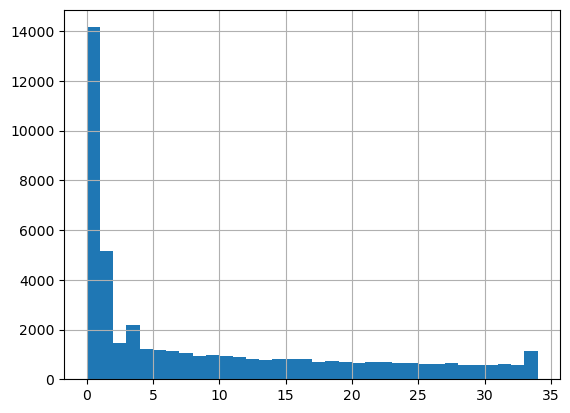

In [31]:
tracks.query('consequent_holes == 0 and pred == 0').first_hole.hist(bins=34)

In [32]:
len(tracks.query('hit_id_1 != -1 and pred == 1')) / len(tracks.query('hit_id_1 != -1 and pred != -1'))

0.9445020795854465

In [33]:
len(tracks.query('hit_id_1 == -1 and pred == 1')) / len(tracks.query('hit_id_1 == -1 and pred != -1'))

0.703311867525299

In [34]:
len(tracks.query('hit_id_1 == -1 and pred != -1')) / len(tracks.query('pred != -1'))

0.020111401086052662

In [35]:
tracks.query('first_hole == 1 and pred == 0')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole,consequent_holes
554,2,1650021,650.889542,-75.727179,1578.337664,0,165031954,-1,165031955,165031956,...,165031980,165031981,165031982,165031983,165031984,165031985,35,3,1,0
579,2,1950024,817.800940,312.768371,-1084.203791,0,194806460,-1,194806461,194806462,...,194806488,194806489,194806490,194806491,194806492,194806493,35,1,1,0
705,3,1150034,335.021459,483.768956,1231.432972,0,115106165,-1,115106166,115106167,...,115106193,115106194,115106195,115106196,115106197,115106198,35,1,1,0
796,4,41,-267.596866,430.679969,1075.402323,0,4263,-1,4264,4265,...,4290,4291,4292,4293,4294,4295,35,2,1,0
833,4,400041,-295.912395,707.430862,-1053.173679,0,40019389,-1,40019390,40019391,...,-1,40019416,40019417,40019418,40019419,40019420,35,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971754,4994,599940,276.828120,-153.972062,-840.906399,0,60130794,-1,-1,60130795,...,60130820,60130821,60130822,60130823,-1,-1,33,3,1,1
971769,4994,699945,-143.171838,-85.240788,117.353644,0,70205289,-1,70205290,70205291,...,70205316,70205317,70205318,70205319,70205320,70205321,35,2,1,0
971856,4994,1599946,-215.434942,85.428649,-319.122925,0,159992825,-1,159992826,159992827,...,159992853,159992854,159992855,159992856,159992857,159992858,35,1,1,0
972159,4996,1049964,252.818388,96.090285,897.267999,0,105094766,-1,105094767,105094768,...,-1,-1,-1,-1,-1,-1,29,1,1,0


In [43]:
tracks.query('hit_id_0 in @tracks.query("first_hole == 1 and pred == 0").hit_id_0 and pred != 0')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole,consequent_holes
972977,5,-1,NaN,NaN,NaN,-1,14985474,-1,-1,75171203,...,-1,-1,-1,-1,-1,-1,4,2,1,1
973079,11,-1,NaN,NaN,NaN,-1,50084715,-1,50084716,50084717,...,-1,-1,-1,-1,-1,-1,13,1,1,0
973146,15,-1,NaN,NaN,NaN,-1,105115916,105116051,105116052,105116053,...,105116079,105116080,105116081,105116082,105116083,105116084,35,0,0,0
973163,16,-1,NaN,NaN,NaN,-1,55167466,-1,-1,55167739,...,-1,-1,-1,-1,-1,-1,4,2,1,1
973266,22,-1,NaN,NaN,NaN,-1,179848447,-1,179848448,179848449,...,-1,-1,-1,-1,-1,-1,7,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055999,4968,-1,NaN,NaN,NaN,-1,90097864,120079983,90097865,90097866,...,90097891,90097892,90097893,90097894,90097895,90097896,35,1,24,0
1056039,4971,-1,NaN,NaN,NaN,-1,39987831,-1,-1,155032694,...,-1,-1,-1,-1,-1,-1,4,2,1,1
1056061,4972,-1,NaN,NaN,NaN,-1,174907926,-1,-1,150031450,...,-1,-1,-1,-1,-1,-1,4,2,1,1
1056174,4978,-1,NaN,NaN,NaN,-1,184788490,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,5,3,1,2


In [85]:
tracks.query('hit_id_0 == 86083')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole,consequent_holes
427,90,4,20.837511,-291.343976,181.396879,0,86083,-1,86084,-1,...,86110,86111,86112,86113,86114,86115,35,2,1,0


In [87]:
tracks.query('event_id == 90 and track == 0')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole,consequent_holes
423,90,0,102.690972,-977.311957,1503.420434,1,85945,85946,85947,85948,...,85974,85975,85976,85977,85978,85979,35,0,0,0


In [34]:
events.query('event == 90 and track == 1')

,event,x,y,z,station,track,px,py,pz,vtxx,vtxy,vtxz,index_old
14552,90,-0.243129,-0.203860,-0.191313,0,1,-112.058394,-134.884245,-189.341763,7.431086,-4.477781,-163.404011,85980
14553,90,-0.255756,-0.219887,-0.199172,1,1,-108.931925,-137.421537,-189.341763,7.431086,-4.477781,-163.404011,85981
14554,90,-0.268574,-0.235784,-0.207074,2,1,-105.740877,-139.891780,-189.341763,7.431086,-4.477781,-163.404011,85982
14555,90,-0.280522,-0.252463,-0.215005,3,1,-102.486075,-142.293527,-189.341763,7.431086,-4.477781,-163.404011,85983
14556,90,-0.292403,-0.269204,-0.222869,4,1,-99.168355,-144.625311,-189.341763,7.431086,-4.477781,-163.404011,85984
14557,90,-0.303811,-0.286362,-0.230853,5,1,-95.788564,-146.885650,-189.341763,7.431086,-4.477781,-163.404011,85985
14558,90,-0.314901,-0.303782,-0.238727,6,1,-92.347559,-149.073041,-189.341763,7.431086,-4.477781,-163.404011,85986
14559,90,-0.325539,-0.321581,-0.246658,7,1,-88.846211,-151.185959,-189.341763,7.431086,-4.477781,-163.404011,85987
14560,90,-0.335980,-0.339493,-0.254667,8,1,-85.285401,-153.222856,-189.341763,7.431086,-4.477781,-163.404011,85988
14561,90,-0.345998,-0.357728,-0.262777,9,1,-81.666026,-155.182162,-189.341763,7.431086,-4.477781,-163.404011,85989


In [55]:
model = evaluator.loaded_model_state[1][0]
printing = False

In [65]:
hits_13 = torch.from_numpy(events.query('event == 90 and track == 1')[['x', 'y', 'z']].values).float().to('cuda').unsqueeze(0)
hits_13

tensor([[[-0.2431, -0.2039, -0.1913],
         [-0.2558, -0.2199, -0.1992],
         [-0.2686, -0.2358, -0.2071],
         [-0.2805, -0.2525, -0.2150],
         [-0.2924, -0.2692, -0.2229],
         [-0.3038, -0.2864, -0.2309],
         [-0.3149, -0.3038, -0.2387],
         [-0.3255, -0.3216, -0.2467],
         [-0.3360, -0.3395, -0.2547],
         [-0.3460, -0.3577, -0.2628],
         [-0.3554, -0.3765, -0.2708],
         [-0.3734, -0.4144, -0.2870],
         [-0.3816, -0.4339, -0.2951],
         [-0.3894, -0.4538, -0.3033],
         [-0.3968, -0.4737, -0.3116],
         [-0.4036, -0.4941, -0.3198],
         [-0.4102, -0.5146, -0.3281],
         [-0.4161, -0.5354, -0.3364],
         [-0.4217, -0.5564, -0.3448],
         [-0.4267, -0.5776, -0.3532],
         [-0.4314, -0.5990, -0.3616],
         [-0.4353, -0.6208, -0.3702],
         [-0.4388, -0.6428, -0.3787],
         [-0.4417, -0.6650, -0.3873],
         [-0.4441, -0.6874, -0.3961],
         [-0.4460, -0.7100, -0.4048],
         [-0

In [66]:
pred_1 = model.exec_model(hits_13, 2)
pred_1

tensor([[-0.2683, -0.2362, -0.2071,  0.0057, -0.2801, -0.2529, -0.2152,  0.0063]],
       device='cuda:0')

In [62]:
hits_13[:, 1] = pred_1[:, :3]
hits_13

tensor([[[-0.2431, -0.2039, -0.1913],
         [-0.2584, -0.2168, -0.1987],
         [-0.2686, -0.2358, -0.2071],
         [-0.2805, -0.2525, -0.2150],
         [-0.2924, -0.2692, -0.2229],
         [-0.3038, -0.2864, -0.2309],
         [-0.3149, -0.3038, -0.2387],
         [-0.3255, -0.3216, -0.2467],
         [-0.3360, -0.3395, -0.2547],
         [-0.3460, -0.3577, -0.2628],
         [-0.3554, -0.3765, -0.2708],
         [-0.3734, -0.4144, -0.2870],
         [-0.3816, -0.4339, -0.2951],
         [-0.3894, -0.4538, -0.3033],
         [-0.3968, -0.4737, -0.3116],
         [-0.4036, -0.4941, -0.3198],
         [-0.4102, -0.5146, -0.3281],
         [-0.4161, -0.5354, -0.3364],
         [-0.4217, -0.5564, -0.3448],
         [-0.4267, -0.5776, -0.3532],
         [-0.4314, -0.5990, -0.3616],
         [-0.4353, -0.6208, -0.3702],
         [-0.4388, -0.6428, -0.3787],
         [-0.4417, -0.6650, -0.3873],
         [-0.4441, -0.6874, -0.3961],
         [-0.4460, -0.7100, -0.4048],
         [-0

In [64]:
pred_2 = model.exec_model(hits_13, 2)
pred_2

tensor([[-0.2738, -0.2300, -0.2061,  0.0059, -0.2892, -0.2429, -0.2137,  0.0066]],
       device='cuda:0')

In [39]:
(tracks.with_holes == 0).sum() / len(tracks)

0.5243380962813304

In [55]:
i = 0
((tracks[STATION_COLUMNS[i]] == -1) * (tracks[STATION_COLUMNS[i + 1]] == -1)).values.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
for i in range(N_STATIONS - 1):
    if ((tracks[STATION_COLUMNS[i]] == -1) * (tracks[STATION_COLUMNS[i + 1]] == -1)).any():
        print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [34]:
np.unique(tracks.with_holes, return_counts=True)[0], np.unique(tracks.with_holes, return_counts=True)[1] / len(tracks)

(array([0, 1, 2, 3, 4, 5]),
 array([7.25213902e-01, 2.33326888e-01, 3.74711977e-02, 3.69797457e-03,
        2.73924042e-04, 1.61131790e-05]))

In [31]:
tracks.query('pred == 0 and first_hole == 1')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_28,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole
428,2,50020,81.115840,-169.874294,9.346013,0,5009507,-1,5009508,5009509,...,5009534,5009535,5009536,5009537,5009538,5009539,5009540,35,1,1
440,2,68771,-56.182256,467.322612,1411.364777,0,6911891,-1,6911892,6911893,...,6911918,6911919,6911920,6911921,6911922,-1,-1,33,1,1
466,2,106270,346.600095,359.342051,-82.823331,0,10682733,-1,10682734,10682735,...,10682759,10682760,10682761,10682762,10682763,10682764,10682765,35,2,1
585,3,25035,-628.391860,-229.648097,-377.798959,0,2510737,-1,2510738,2510739,...,2510764,2510765,2510766,2510767,2510768,2510769,2510770,35,1,1
642,3,106286,451.947145,-561.076954,1988.902404,0,10683007,-1,10683008,10683009,...,10683034,10683035,10683036,10683037,10683038,10683039,10683040,35,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121926,618,243681,-275.800424,-0.055969,-321.851522,0,24453696,-1,24453697,24453698,...,24453723,24453724,24453725,24453726,24453727,24453728,24453729,35,1,1
122274,620,206200,-321.662408,163.955379,-282.486906,0,20683429,-1,20683430,20683431,...,20683455,20683456,20683457,20683458,20683459,20683460,20683461,35,2,1
122308,621,12460,795.624509,-296.952647,2636.334566,0,1233901,-1,1233902,1233903,...,1233928,1233929,1233930,1233931,-1,-1,-1,32,1,1
122850,623,237487,226.081170,281.466717,-206.833647,0,23835853,-1,23835854,23835855,...,23835880,23835881,23835882,23835883,23835884,23835885,23835886,35,1,1


In [32]:
tracks.query('event_id == 19')

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_28,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,len,with_holes,first_hole
3777,19,6444,-9.869409,173.045303,-7.398164,0,616673,616674,616675,616676,...,616701,616702,616703,616704,616705,616706,616707,35,0,0
3803,19,25196,638.480700,-427.900675,-533.460831,0,2525760,2525761,2525762,2525763,...,2525788,2525789,2525790,2525791,2525792,2525793,2525794,35,0,0
3813,19,37695,266.241821,687.945946,-479.138277,0,3782138,3782139,3782140,3782141,...,3782165,3782166,3782167,3782168,3782169,3782170,3782171,35,1,5
3842,19,68946,108.552286,-70.442081,244.029706,0,6928127,6928128,6928129,6928130,...,6928155,6928156,6928157,6928158,6928159,6928160,6928161,35,0,0
3853,19,87693,524.303459,-289.386953,308.302761,0,8754323,8754324,8754325,8754326,...,8754351,8754352,8754353,8754354,8754355,8754356,8754357,35,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123928,19,-1,NaN,NaN,NaN,-1,20703112,6928945,-1,1893628,...,-1,-1,-1,-1,-1,-1,-1,4,1,2
123929,19,-1,NaN,NaN,NaN,-1,20703459,9428201,17640169,6929467,...,-1,-1,-1,-1,-1,-1,-1,4,0,4
123930,19,-1,NaN,NaN,NaN,-1,21966534,16377411,11960839,11960840,...,11960865,11960866,11960867,11960868,11960869,11960870,11960871,35,0,0
123931,19,-1,NaN,NaN,NaN,-1,21967509,1261333,1261334,1261335,...,-1,-1,-1,-1,-1,-1,-1,9,0,9


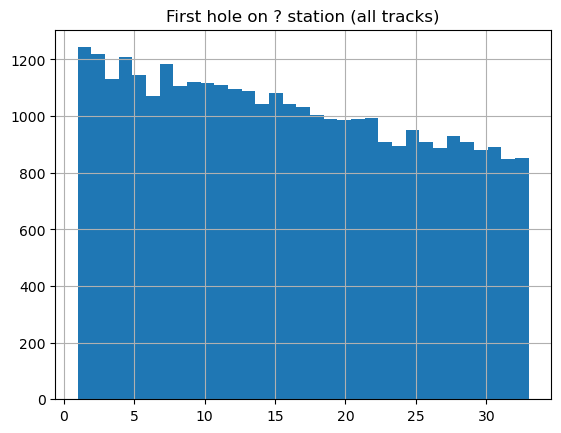

In [33]:
tracks.query('pred != -1 and with_holes > 0').first_hole.hist(bins=33)
plt.title("First hole on ? station (all tracks)")
plt.show()

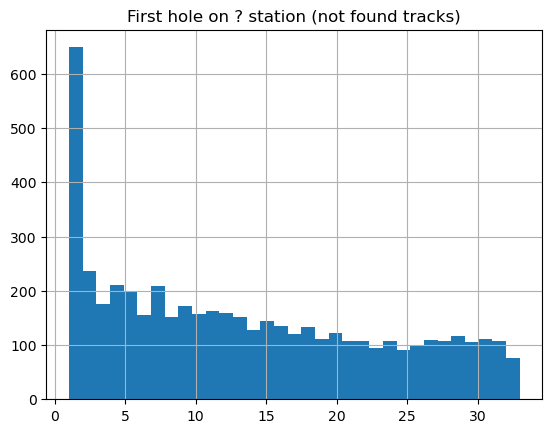

In [34]:
tracks.query('pred == 0 and with_holes > 0').first_hole.hist(bins=33)
plt.title("First hole on ? station (not found tracks)")
plt.show()

In [48]:
for i in tqdm(range(625)):
    os.mkdir(f'faiss_samples/event{i}')
    with open(f'faiss_samples/event{i}/index.npy', 'wb') as f:
        np.save(f, res_1[i])
    os.mkdir(f'faiss_samples/event{i}/samples')
    for j in range(34):
        with open(f'faiss_samples/event{i}/samples/query{j}.npy', 'wb') as f:
            np.save(f, res_2[i][j])

100%|██████████| 625/625 [00:29<00:00, 21.02it/s]


In [3]:
import numpy as np
import faiss
from tqdm import tqdm

In [28]:
indexes = []
queries = []
for i in tqdm(range(625)):
    index_np = np.load(f'faiss_samples/event{i}/index.npy')
    indexes.append(torch.from_numpy(index_np))
    queries.append([])
    for j in range(34):
        query = np.load(f'faiss_samples/event{i}/samples/query{j}.npy')
        queries[-1].append(torch.from_numpy(query))

100%|██████████| 625/625 [00:15<00:00, 40.15it/s]


In [11]:
DEVICE = 'cuda'

In [29]:
indexes_f = []
for index_np in tqdm(indexes):
    index = faiss.IndexFlatL2(3)
    if DEVICE == 'cuda':
        index = faiss.index_cpu_to_gpu(faiss_gpu, 0, index)
    index.add(index_np)
    indexes_f.append(index)

100%|██████████| 625/625 [00:02<00:00, 276.71it/s]


In [30]:
times = []
event_times = []
for index, queries_curr in tqdm(zip(indexes_f, queries)):
    event_start = time.time()
    #index = index.to(DEVICE)
    queries_gpu = [query.to(DEVICE) for query in queries_curr]
    for query in queries_gpu:
        #start_time = time.time()
        pr.enable()
        dist, i = index.search(query, 1)
        pr.disable()
        #times.append(time.time() - start_time)
    event_times.append(time.time() - event_start)

625it [00:11, 54.45it/s]


In [116]:
np.array(times).mean()

nan

In [31]:
np.array(event_times).mean()

0.018213314819335937

In [33]:
times = []
event_times = []
for index, queries_curr in tqdm(zip(indexes, queries)):
    event_start = time.time()
    index = index.to(DEVICE)
    queries_gpu = [query.to(DEVICE) for query in queries_curr]
    for query in queries_gpu:
        #start_time = time.time()
        pr.enable()
        dist, i = search_t(query, index)
        pr.disable()
        #times.append(time.time() - start_time)
    event_times.append(time.time() - event_start)

625it [00:09, 66.65it/s]


In [112]:
np.array(times).mean()

0.0001086120044483858

In [34]:
np.array(event_times).mean()

0.014857003784179687

In [52]:
indexes[0].shape, queries[0][0].shape

(torch.Size([43596, 3]), torch.Size([1311, 3]))

In [70]:
a = indexes_f[0].search(queries[0][0], 1)
a

(tensor([[9.2760e-05],
         [2.9460e-05],
         [3.4899e-05],
         ...,
         [6.8820e-04],
         [1.7363e-03],
         [1.6291e-03]]),
 tensor([[    1],
         [   36],
         [   71],
         ...,
         [ 8365],
         [18068],
         [27141]]))

In [71]:
b = torch.min(torch.cdist(queries[0][0], indexes[0]), dim=1)
b

torch.return_types.min(
values=tensor([0.0096, 0.0054, 0.0059,  ..., 0.0262, 0.0417, 0.0404]),
indices=tensor([    1,    36,    71,  ...,  8365, 18068, 27141]))

In [79]:
(a[1].flatten() == b[1]).all()

tensor(True)

In [82]:
(a[0].flatten() == b[0]**2)

tensor([False, False,  True,  ...,  True, False, False])

In [83]:
(b[0]**2)[0]

tensor(9.2760e-05)

In [87]:
a[0][0]

tensor([9.2760e-05])

In [51]:
res_1[0].shape

(43596, 3)

In [53]:
total_time = 0
for ev_id in tqdm(range(625)):
    index = faiss.IndexFlatL2(3)
    index.add(res_1[ev_id])
    
    start_time = time.time()
    for i in range(34):
        dist, i = index.search(res_2[ev_id][i], 1)
    total_time += time.time() - start_time
total_time / 625    

100%|██████████| 625/625 [05:58<00:00,  1.74it/s]


0.5731646583557128

In [29]:
len(res_1)

625

In [30]:
len(res_2)

625

In [34]:
res_2[0]

IndexError: list index out of range

In [32]:
pr = profile.Profile()
pr.disable()

In [38]:
pr.enable()
for pair in tqdm(res_1, smoothing=0):
    a = search_distance(pair[0].cpu(), pair[1], 1)
pr.disable()

 13%|█▎        | 2721/21250 [00:06<00:47, 392.14it/s]

KeyboardInterrupt



In [40]:
for pair in tqdm(res_1, smoothing=0):
    #pr.enable()
    a = pair[1].range_search(pair[0].cpu().contiguous(), 0.00000087)
    #pr.disable()

100%|██████████| 21250/21250 [04:16<00:00, 82.89it/s]


In [47]:
pr.disable()

In [41]:
pr.dump_stats('profile1.pstat')

In [36]:
res_1[0]

[tensor([[ 0.2097, -0.2642,  0.2583],
         [ 0.3302, -0.0689, -0.0034],
         [-0.3303, -0.0660, -0.1276],
         ...,
         [ 0.3023,  0.1424,  0.9143],
         [-0.2277,  0.2486, -0.6279],
         [-0.3299, -0.0750,  0.7296]], device='cuda:0'),
 <faiss.swigfaiss_avx2.GpuIndexFlat; proxy of <Swig Object of type 'faiss::gpu::GpuIndexFlat *' at 0x7f5b8db2de70> >]

In [32]:
result = results_tracknet[0].copy()
for ev in sorted(result.event_id.unique()):
    n_ghosts = len(result.query('event_id == @ev and pred == -1'))
    if n_ghosts > 0:
        max_track = result.query('event_id == @ev').track.max()
        result.track[(result.event_id == ev) & (result.pred ==-1)] = list(range(max_track + 1, max_track + n_ghosts + 1))


KeyboardInterrupt



In [60]:
events_1 = events.set_index('index_old')

In [61]:
hits = []
for i in tqdm(range(0, 25000, 100)):
    result_part = result.query('@i <= event_id < @i + 100')
    events_1_part = events_1.query('@i <= event < @i + 100')
    for track in result_part.itertuples():
        hits_ids = np.array(track[7:])
        hits_df = events_1_part.loc[hits_ids[hits_ids > 0]]
        hits_df.track = track.track
        hits_df['pred'] = track.pred
        hits.append(hits_df)

100%|██████████| 250/250 [02:20<00:00,  1.78it/s]


In [62]:
def denorm_coord(coord, min_val, max_val):
   return ((coord + 1) * (max_val - min_val) / 2) + min_val

In [63]:
hits_to_kf = pd.concat(hits)
hits_to_kf.x = denorm_coord(hits_to_kf.x, constraints['x'][0], constraints['x'][1])
hits_to_kf.y = denorm_coord(hits_to_kf.y, constraints['y'][0], constraints['y'][1])
hits_to_kf.z = denorm_coord(hits_to_kf.z, constraints['z'][0], constraints['z'][1])

In [64]:
hits_to_kf.sort_values('event', inplace=True)

In [ ]:
hits_to_kf.to_csv('1.txt', columns=['event', 'x', 'y', 'z', 'station', 'track', 'pred', 'px', 'py', 'pz', 'vtxx', 'vtxy', 'vtxz'], sep="\t", index=False, header=False)

In [67]:
hits_to_kf.query('1998 <= event < 2001')

,event,x,y,z,station,track,px,py,pz,vtxx,vtxy,vtxz,pred
index_old,,,,,,,,,,,,,
1965321,1998,847.210684,69.260295,1365.049437,34,6,880.697043,-26.910815,1516.526226,-3.520884,7.680272,-100.968644,1
1965239,1998,-254.308421,-593.136274,92.067031,22,4,-114.895350,-457.833099,140.536567,-3.520884,7.680272,-100.968644,1
1965319,1998,812.929236,70.151248,1305.875249,32,6,880.904287,-18.950186,1516.526226,-3.520884,7.680272,-100.968644,1
1965162,1998,525.097192,-30.167994,-108.972035,15,2,956.178331,6.166948,-14.579927,-3.520884,7.680272,-100.968644,1
1965161,1998,507.920465,-30.247368,-108.831536,14,2,956.195684,2.201532,-14.579927,-3.520884,7.680272,-100.968644,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966132,2000,26.837894,644.714221,127.809479,22,0,-55.375151,469.696849,41.928624,-5.493511,12.788769,70.324521,1
1966131,2000,28.787179,627.553910,126.118388,21,0,-51.393972,470.149122,41.928624,-5.493511,12.788769,70.324521,1
1966130,2000,30.583698,610.512219,124.876682,20,0,-47.411735,470.567386,41.928624,-5.493511,12.788769,70.324521,1


In [68]:
pxpypz = pd.read_csv('result.csv', names=['event_id', 'track', 'px', 'py', 'pz'])
pxpypz

,event_id,track,px,py,pz
0,0,0,-315.1520,367.921,-1377.7600
1,0,1,361.1930,-248.329,276.2310
2,0,3,301.7060,273.536,-22.3634
3,0,4,309.3280,178.598,37.2284
4,0,5,330.0670,-215.056,-17.5333
...,...,...,...,...,...
113289,24998,1,402.5070,344.514,480.2900
113290,24998,3,-97.5795,255.206,261.8850
113291,24999,0,-173.3660,-220.910,61.7635
113292,24999,1,-307.2170,-915.864,-365.9730


In [69]:
merged_df = pd.merge(pxpypz, result, how='inner',
                           on=['event_id', 'track'],
                           suffixes=[None, '_y'])
merged_df.drop(['px_y', 'py_y', 'pz_y'], axis=1, inplace=True)

merged_df['track'][merged_df.pred == -1] = -1

merged_df.pred = merged_df.pred.astype('int32')
merged_df.track = merged_df.track.astype('int32')
merged_df.event_id = merged_df.event_id.astype('int32')

merged_df.px = merged_df.px.astype('float32')
merged_df.py = merged_df.py.astype('float32')
merged_df.pz = merged_df.pz.astype('float32')

In [70]:
new_tracks = []
ind_col = []
for i in tqdm(range(0, 25000, 100)):
    result_part = result.query('@i <= event_id < @i + 100')
    pxpypz_part = pxpypz.query('@i <= event_id < @i + 100')
    for track in result_part.itertuples():
        if track.pred == -1:
            pxpypz_part_track = pxpypz_part.query('event_id == @track.event_id and track == @track.track')
            if len(pxpypz_part_track) > 0:
                track_dict = {}
                ind_col.append(track.Index)
                #track['index'] = pxpypz_part_track.index[0]
                track_dict['px'] = pxpypz_part_track.px.iloc[0]
                track_dict['py'] = pxpypz_part_track.py.iloc[0]
                track_dict['pz'] = pxpypz_part_track.pz.iloc[0]
                new_tracks.append(track_dict)
new_tracks = pd.DataFrame(new_tracks)
new_tracks = new_tracks.astype(result[['px', 'py', 'pz']].dtypes)
new_tracks.set_index(np.array(ind_col), inplace=True)
new_tracks

100%|██████████| 250/250 [00:02<00:00, 83.83it/s]


,px,py,pz
123714,283.2900,-402.9040,1398.7900
123716,-469.4350,-255.9620,139.7350
123718,383.4010,963.6810,-961.7580
123719,-112.3100,609.4410,-542.0760
123721,-904.1440,-12.5735,1287.9500
...,...,...,...
124899,285.1210,-128.2730,43.0282
124900,-596.8500,-131.9780,-1223.8600
124903,222.8960,-76.3464,222.2360
124904,636.3870,417.0740,-2353.2800


In [71]:
joined_res = result.join(new_tracks, rsuffix='_kf')
joined_res.px = joined_res.px.fillna(joined_res.px_kf)
joined_res.py = joined_res.py.fillna(joined_res.py_kf)
joined_res.pz = joined_res.pz.fillna(joined_res.pz_kf)
joined_res.drop(['px_kf', 'py_kf', 'pz_kf'], axis=1, inplace=True)
joined_res.track[joined_res.pred == -1] = -1
joined_res

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_25,hit_id_26,hit_id_27,hit_id_28,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34
71,21,2,-100.322289,-0.125593,88.404794,0,10009,10010,10011,10012,...,10034,10035,10036,10037,10038,10039,10040,10041,10042,10043
114,30,0,354.452322,372.719135,-134.394710,0,18354,18355,18356,18357,...,18379,18380,18381,18382,18383,18384,18385,18386,18387,18388
260,58,6,-445.749154,-895.133998,927.094437,0,45585,45586,45587,45588,...,45610,45611,45612,45613,45614,45615,45616,45617,45618,45619
980,216,5,-268.124784,-52.779568,91.292301,0,185665,185666,185667,185668,...,185690,185691,185692,185693,185694,185695,185696,185697,185698,185699
981,216,6,-944.163070,-138.774238,318.975572,0,185700,185701,185702,185703,...,185725,185726,185727,185728,185729,185730,185731,185732,185733,185734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124904,24853,-1,636.387000,417.074000,-2353.280000,-1,23747726,23747727,23747728,23747729,...,23747751,-1,-1,-1,-1,-1,-1,-1,-1,-1
124905,24869,-1,NaN,NaN,NaN,-1,23766025,23766026,23766027,23766028,...,23766050,23766051,23766052,23766053,23766054,23766055,23766056,23766057,23766058,-1
124906,24921,-1,NaN,NaN,NaN,-1,23815096,23814234,23814235,23814236,...,23814258,23814259,23814260,23814261,23814262,23814263,23814264,23814265,23814266,23814267
124907,24938,-1,NaN,NaN,NaN,-1,23828945,23828263,23828264,23828265,...,23828287,23828288,23828289,23828290,23828291,23828292,23828293,23828294,23828295,23828296


In [79]:
joined_res

,event_id,track,px,py,pz,pred,hit_id_0,hit_id_1,hit_id_2,hit_id_3,...,hit_id_28,hit_id_29,hit_id_30,hit_id_31,hit_id_32,hit_id_33,hit_id_34,pt,cos_t,a_phi
71,21,2,-100.322289,-0.125593,88.404794,0,10009,10010,10011,10012,...,10037,10038,10039,10040,10041,10042,10043,100.322365,0.661138,-1.572048
114,30,0,354.452322,372.719135,-134.394710,0,18354,18355,18356,18357,...,18382,18383,18384,18385,18386,18387,18388,514.350098,-0.252803,0.760283
260,58,6,-445.749154,-895.133998,927.094437,0,45585,45586,45587,45588,...,45613,45614,45615,45616,45617,45618,45619,999.978577,0.679877,-2.679571
980,216,5,-268.124784,-52.779568,91.292301,0,185665,185666,185667,185668,...,185693,185694,185695,185696,185697,185698,185699,273.270172,0.316859,-1.765158
981,216,6,-944.163070,-138.774238,318.975572,0,185700,185701,185702,185703,...,185728,185729,185730,185731,185732,185733,185734,954.307190,0.317009,-1.716733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124904,24853,-1,636.387000,417.074000,-2353.280000,-1,23747726,23747727,23747728,23747729,...,-1,-1,-1,-1,-1,-1,-1,760.880493,-0.951501,0.990650
124905,24869,-1,NaN,NaN,NaN,-1,23766025,23766026,23766027,23766028,...,23766053,23766054,23766055,23766056,23766057,23766058,-1,NaN,NaN,NaN
124906,24921,-1,NaN,NaN,NaN,-1,23815096,23814234,23814235,23814236,...,23814261,23814262,23814263,23814264,23814265,23814266,23814267,NaN,NaN,NaN
124907,24938,-1,NaN,NaN,NaN,-1,23828945,23828263,23828264,23828265,...,23828290,23828291,23828292,23828293,23828294,23828295,23828296,NaN,NaN,NaN


In [72]:
results_tracknet[0].isna().sum()

event_id        0
track           0
px           1195
py           1195
pz           1195
pred            0
hit_id_0        0
hit_id_1        0
hit_id_2        0
hit_id_3        0
hit_id_4        0
hit_id_5        0
hit_id_6        0
hit_id_7        0
hit_id_8        0
hit_id_9        0
hit_id_10       0
hit_id_11       0
hit_id_12       0
hit_id_13       0
hit_id_14       0
hit_id_15       0
hit_id_16       0
hit_id_17       0
hit_id_18       0
hit_id_19       0
hit_id_20       0
hit_id_21       0
hit_id_22       0
hit_id_23       0
hit_id_24       0
hit_id_25       0
hit_id_26       0
hit_id_27       0
hit_id_28       0
hit_id_29       0
hit_id_30       0
hit_id_31       0
hit_id_32       0
hit_id_33       0
hit_id_34       0
dtype: int64

In [73]:
joined_res.isna().sum()

event_id       0
track          0
px           514
py           514
pz           514
pred           0
hit_id_0       0
hit_id_1       0
hit_id_2       0
hit_id_3       0
hit_id_4       0
hit_id_5       0
hit_id_6       0
hit_id_7       0
hit_id_8       0
hit_id_9       0
hit_id_10      0
hit_id_11      0
hit_id_12      0
hit_id_13      0
hit_id_14      0
hit_id_15      0
hit_id_16      0
hit_id_17      0
hit_id_18      0
hit_id_19      0
hit_id_20      0
hit_id_21      0
hit_id_22      0
hit_id_23      0
hit_id_24      0
hit_id_25      0
hit_id_26      0
hit_id_27      0
hit_id_28      0
hit_id_29      0
hit_id_30      0
hit_id_31      0
hit_id_32      0
hit_id_33      0
hit_id_34      0
dtype: int64

In [144]:
start_time = time.time()
results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=1)
end_time = time.time()
print(f'solving took {end_time - start_time} seconds')

[solve results] start
[solve results] finish
[solve results] final stats:
==========EVALUATION RESULTS==========
Total events evaluated: 1000
Total tracks evaluated: 5017
Track Efficiency (recall): 0.9946 
Track Purity (precision): 0.9885 
Fully reconstructed event ratio: 0.9740
Mean cpu time per event: 0.0004 sec (2729.26 events per second) 
Mean gpu time per event: 0.0535 sec (18.71 events per second) 
==========EVALUATION RESULTS==========
solving took 0.0883939266204834 seconds


In [80]:
results_tracknet[0].fillna(0, inplace=True)

## Plots

In [44]:
%matplotlib inline

In [59]:
def draw_track(ax, x, y, z, label, track_num):
    if label == 1:
        col = 'green'#(0., 1.0, 0.000, 0.9)
    elif label == 0:
        col = (0, 0.0, 1, 0.9)
    elif label == -1:
        pass
        col = (1, 0.0, 0.000, 0.9)
    else:
        col = (0, 1, 0, 0.3)
    val_x = x#track[:,0]
    val_y = y#track[:,2]
    val_z = z#track[:,1# ]
    #if track_num != 22 and track_num != 1285:
    #    col = list(col)[:3] + [0]
    line, = ax.plot(val_x, val_y, zs=val_z, color=col, label=f'track_num={track_num}', picker=10)
    #ax.scatter(val_x, val_y, zs=val_z, color=col)
    return line


def draw_event(ev_id, events_df, projection='xz', draw_unproc=False, columns=['x', 'y', 'z']):
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if projection == 'xz':
        ax.view_init(azim=200, elev=10)
        ax.set_xlabel(columns[0])
    else:
        ax.view_init(azim=360, elev=0)
        ax.set_ylabel(columns[1])
    i = 0
    lines = []

    hits_real = events_df.query('event == @ev_id and track >= 0')
    ax.scatter(hits_real[columns[0]], hits_real[columns[1]], zs=hits_real[columns[2]], c='lightgreen', alpha=0.5)
    
    hits_fake = events_df.query('event == @ev_id and track == -1')[:100]
    ax.scatter(hits_fake[columns[0]], hits_fake[columns[1]], zs=hits_fake[columns[2]], c='red', alpha=0.5)

    for tr_id, df in events_df.query('event == @ev_id').groupby('track'):
        if tr_id != -1:
            lines.append(draw_track(ax, df[columns[0]], df[columns[1]], df[columns[2]], 1, tr_id))

    #leg = ax.legend(fancybox=True, shadow=True)
    #lined = {}  # Will map legend lines to original lines.
    #for legline, origline in zip(leg.get_lines(), lines):
    #    legline.set_picker(True)  # Enable picking on the legend line.
    #    lined[legline] = origline

    """def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)
        # Change the alpha on the line in the legend so we can see what lines
        # have been toggled.
        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)"""
    plt.savefig('spd_event.png', dpi=300)
    plt.show()

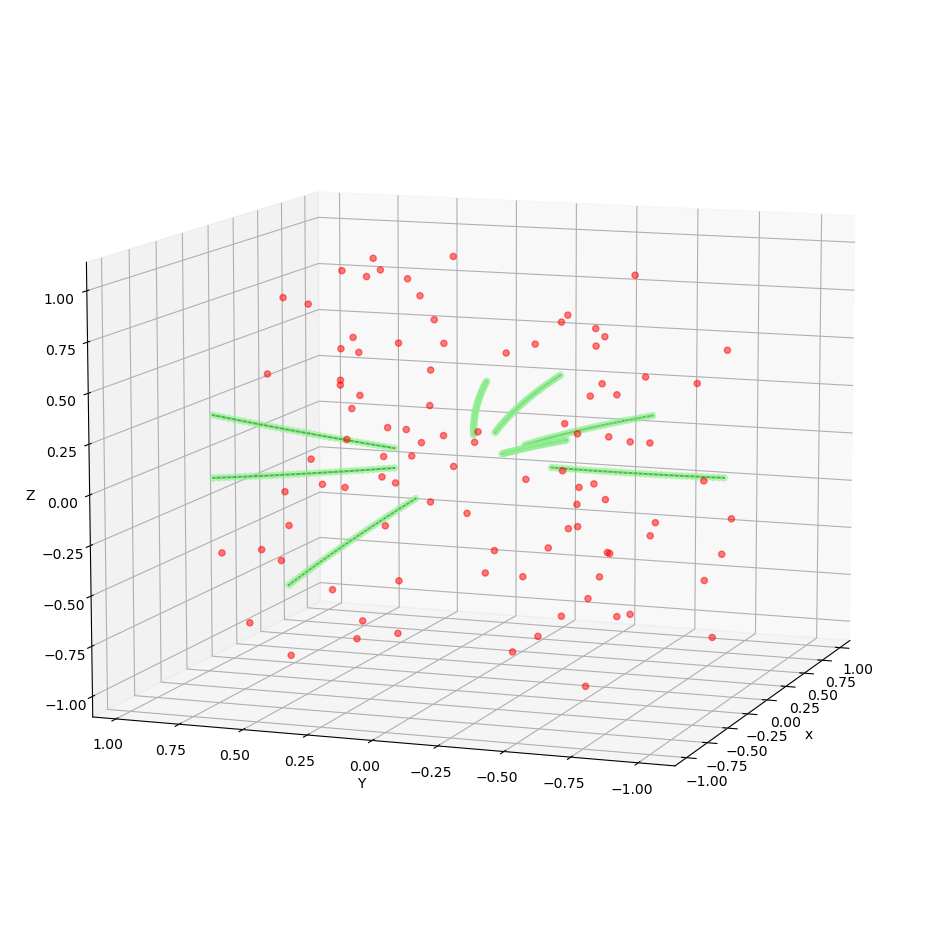

In [60]:
draw_event(7, events)

In [30]:
result = results_tracknet[0].copy()
result['len'] = (result[STATION_COLUMNS] < 0).values.argmax(axis=1)
result.len = result.len.replace(0, N_STATIONS)

for tr_len in sorted(list(result.len.unique())):
    cands = result.query('len == @tr_len')
    try:
        precision = len(cands.query('pred == 1')) / (len(cands.query('pred == -1')) + len(cands.query('pred == 1')))
    except:
        precision = 0
    try:
        recall = len(cands.query('pred == 1')) / (len(cands.query('pred == 0')) + len(cands.query('pred == 1')))
    except:
        recall = 0
    print(f'tracklen = {tr_len}, number = {len(cands.query("pred != -1"))}({len(cands.query("pred != -1"))/len(result.query("pred != -1"))}), precision {precision}, recall {recall}')

tracklen = 3, number = 126(0.0010184781027207915), precision 0, recall 0.0
tracklen = 4, number = 133(0.0010750602195386133), precision 0.41935483870967744, recall 0.9774436090225563
tracklen = 5, number = 123(0.0009942286240845822), precision 0.8243243243243243, recall 0.991869918699187
tracklen = 6, number = 120(0.0009699791454483729), precision 0.9296875, recall 0.9916666666666667
tracklen = 7, number = 139(0.0011235591768110318), precision 0.9448275862068966, recall 0.9856115107913669
tracklen = 8, number = 170(0.0013741371227185281), precision 0.9269662921348315, recall 0.9705882352941176
tracklen = 9, number = 149(0.001204390772265063), precision 0.9125, recall 0.9798657718120806
tracklen = 10, number = 173(0.0013983866013547374), precision 0.9661016949152542, recall 0.9884393063583815
tracklen = 11, number = 182(0.0014711350372633655), precision 0.9516129032258065, recall 0.9725274725274725
tracklen = 12, number = 169(0.0013660539631731251), precision 0.9325842696629213, recall 

In [86]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

MODES = {
    "RECALL":1,
    "PRECISION":2
}
a = []
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode):
    spac = np.linspace(start, end, num=num)
    #print(num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    track_count_for_arr = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if mode == MODES["RECALL"]:
            if elems_real.empty:
                #arr.append(1.)
                continue
            else:
                arr.append(len(elems_pred) / len(elems_real))
                track_count_for_arr.append(len(elems_real))
        elif mode == MODES["PRECISION"]:
            if elems_pred.empty:
                #arr.append(1.)
                continue
            else:
                reco_true = len(elems_pred[elems_pred.track != -1])
                arr.append(reco_true / len(elems_pred))
                track_count_for_arr.append(len(elems_real))
        else:
            raise NotImplemented

        spac_ret.append(spac[i])

    return np.array(arr), np.array(spac_ret), np.array(track_count_for_arr)


def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode, mode):
    y_vals, x_vals, counts_ = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array


    res_x_array = []
    res_box_data = []
    mean_box_array = []
    track_counts_ed = []
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        track_counts_corr = counts_[y_ind]

        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
            continue

        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
        #         if len(np.where(y_vals_corr < 1)) > 0:
        #             print(y_vals_corr)
        #             print(y_vals)
        #             print(beg,end)

        res_box_data.append(y_vals_corr)
        track_counts_ed.append(np.sum(track_counts_corr))

        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array), np.array(track_counts_ed)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    #for box in bp['boxes']:
    # change outline color
    #box.set( color='#7570b3', linewidth=2)
    # change fill color
    #box.set( facecolor = 'silver' )

    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    #for median in bp['medians']:
    #    median.set(color='tab:red', linewidth=3, zorder=30)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=2, ls='-', zorder=10)


##########################
###########################

from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150,
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 subtitle=None,
                 model_name="NO_MODEL_NAME",
                 graph_idx=0, total_indices=-1, spacing=-1,
                 color_line='tab:orange', color_box='red', mode=-1
                 ):
    real_xticks_count = x_ticks

    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks

    delta = 1e-4 if not int_mode else 1

    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac, counts_ = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col, mode)

    maxX = int(end) if int_mode else end
    ax.set_xlabel(col_pretty)
    ax.plot(spac, initial, alpha=0.0, lw=1)

    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()

    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2

        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func

        box_data, ticks_x, mean_data, counts_ed = diagram_func(tracks_real, tracks_pred_true, start, end,
                                                               n_ticks, col, x_ticks, int_mode, mode)
        #print(x_ticks)
        if total_indices > 0:

            width_tuned = delta_x * 2 / total_indices
            pos_tuned = ticks_x - delta_x
            spacings = width_tuned * 0.4
            width_real = width_tuned * 0.6

            ticks_x = pos_tuned + width_tuned * graph_idx + spacings/2 + width_real/2
            delta_x = width_real
        box_data_t = []
        ticks_x_t = []
        delta_x_t = []
        mean_data_t = []
        counts_ed_t = []

        for i, box in enumerate(box_data):
            if len(box) > 4:
                box_data_t.append(box)
                ticks_x_t.append(ticks_x[i])
                mean_data_t.append(mean_data[i])

                counts_ed_t.append(counts_ed[i])

        box_data = np.array(box_data_t)
        ticks_x = np.array(ticks_x_t)
        mean_data = np.array(mean_data_t)

        counts_ed = np.array(counts_ed_t)

        bp = ax.boxplot(box_data, positions=ticks_x,
                        manage_ticks=False, meanline=True, showmeans=True,
                        widths=delta_x,patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
        boxplot_style(bp)
        ret_widths = delta_x
        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
        spl = make_interp_spline(ticks_x, mean_data, k=1)
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)
        #ax.set_xticks(old_ticks)
        if graph_idx == 0:
            for i in range(len(ticks_x)):
                y_pos = 1.01
                x_pos = ticks_x[i] - delta_x/2
                ax.text(x_pos, y_pos, f"{counts_ed[i]}", zorder=80)

    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)

    #if diagram_func is None:
    #ax.set_ylim((0.8, 1.05))
    ax.set_ylim((-0.05, 1.05))
    ticks = ax.get_xticks()
    step = ticks[1] - ticks[0]
    if graph_idx == total_indices-1:
        ax.set_xlim((np.min(ticks_x) - width_tuned-step, np.max(ticks_x)+width_real + step/2))

    for draw_f in custom_draw_funcs:
        draw_f(ax)

    return ret_widths

    ####plt.locator_params(axis='y', nbins=16)


    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()

def draw_for_raw_data(ax, data_x, data_y, data_y_err, color_box, color_line, col_widths, model_name, subtitle):
    data_x = np.array(data_x)
    data_y_init = np.array(data_y)
    dataep = data_y + np.array(data_y_err)
    dataem = data_y - np.array(data_y_err)

    data_y = np.expand_dims(data_y,axis=-1)
    dataep = np.expand_dims(dataep,axis=-1)
    dataem = np.expand_dims(dataem,axis=-1)

    data_y = np.concatenate((data_y, dataep, dataem), axis=1).T
    delta_x = (data_x[1]-data_x[0]) / 2

    width_tuned = delta_x * 2 / 3
    pos_tuned = data_x - delta_x
    spacings = width_tuned * 0.4
    width_real = width_tuned * 0.6

    ticks_x = pos_tuned + width_tuned * 2 + spacings/2 + width_real/2

    bp = ax.boxplot(data_y, positions=ticks_x,
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=col_widths, patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
    boxplot_style(bp)
    xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
    mean_data = data_y_init
    spl = make_interp_spline(ticks_x, mean_data, k=1)  # type: BSpline
    power_smooth = spl(xnew)

    ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)

    pass

def to_recall(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]
    return tracks_real, tracks_pred_true, MODES["RECALL"], "efficiency"

def to_precision(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.track != -1]
    tracks_pred_true = all_tracks_df[(all_tracks_df.pred == 1) | (all_tracks_df.pred == -1)]
    return tracks_real, tracks_pred_true, MODES["PRECISION"], "purity"

def plot_model_results(model_names, model_results_arr, mode_func, funcs_for_kalman=None):

    fig = plt.figure(figsize=(14,16), dpi=80)
    ax1, ax2, ax3 = fig.subplots(nrows=3, ncols=1)
    #    ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharey='all')

    total_models = len(model_names)
    if funcs_for_kalman:
        total_models+=1

    colormap = plt.cm.tab10 #nipy_spectral, Set1,Paired
    colors = [colormap(i) for i in np.linspace(0, 1, 8)]

    widths_for_ax = []
    tit = ""
    for idx, (model_name, model_results) in enumerate(zip(model_names, model_results_arr)):

        all_tracks_df = model_results[0]

        all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
        all_tracks_df['pt'] = all_tracks_df['pt'].astype('float32')
        all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
        all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)

        tracks_real, tracks_pred_true, mode, subtitle  = mode_func(all_tracks_df)

        color_box = colors[idx]
        color_line = colors[idx]
        n_events = model_results_arr[0][0].event_id.nunique()
        tit = f"Models track {subtitle} on {n_events} events"
        ax1.set_title(tit)
        ax1.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax2.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax3.set_ylabel(f'Track {subtitle}', fontsize=12)

        widths_ax = draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)

        widths_for_ax.append([widths_ax])


        widths_ax = draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)
        #
        ##enable on big dataset
        widths_ax = draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350,
                                 n_avg_ticks=48,x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)

    if funcs_for_kalman:
        for idx, ax in enumerate([ax1,ax2,ax3]):
            color_box = colors[-2]
            color_line = colors[-2]
            funcs_for_kalman[idx](ax, widths_for_ax[-1][idx], color_box, color_line)

    for ax in [ax1,ax2,ax3]:
        ax.grid()
        ax.legend(bbox_to_anchor=(1, -0.05))

    fig = plt.gcf()
    handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, -0.05))
    #plt.title()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'

    os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/%s.png'%(''.join([i if (ord(i) < 128) and (ord(i)>ord('a')) else '_' for i in tit])), dpi=300)
    #return all_tracks_df
    plt.show()
    pass

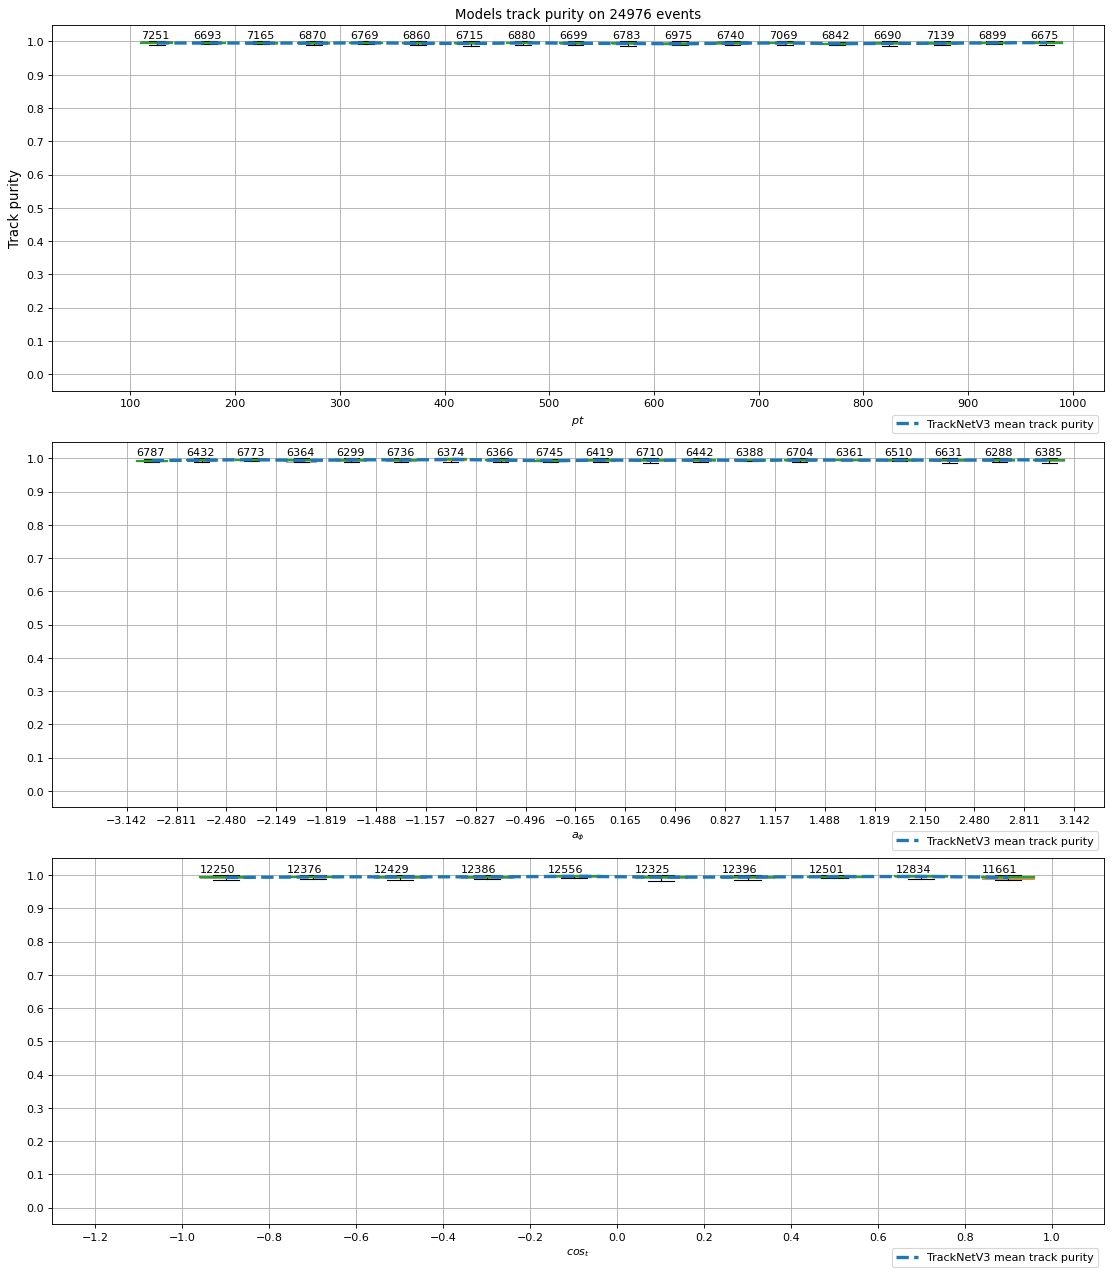

In [87]:
plot_model_results(["TrackNetV3"],    #
                   [[joined_res, ]],
                   to_precision)

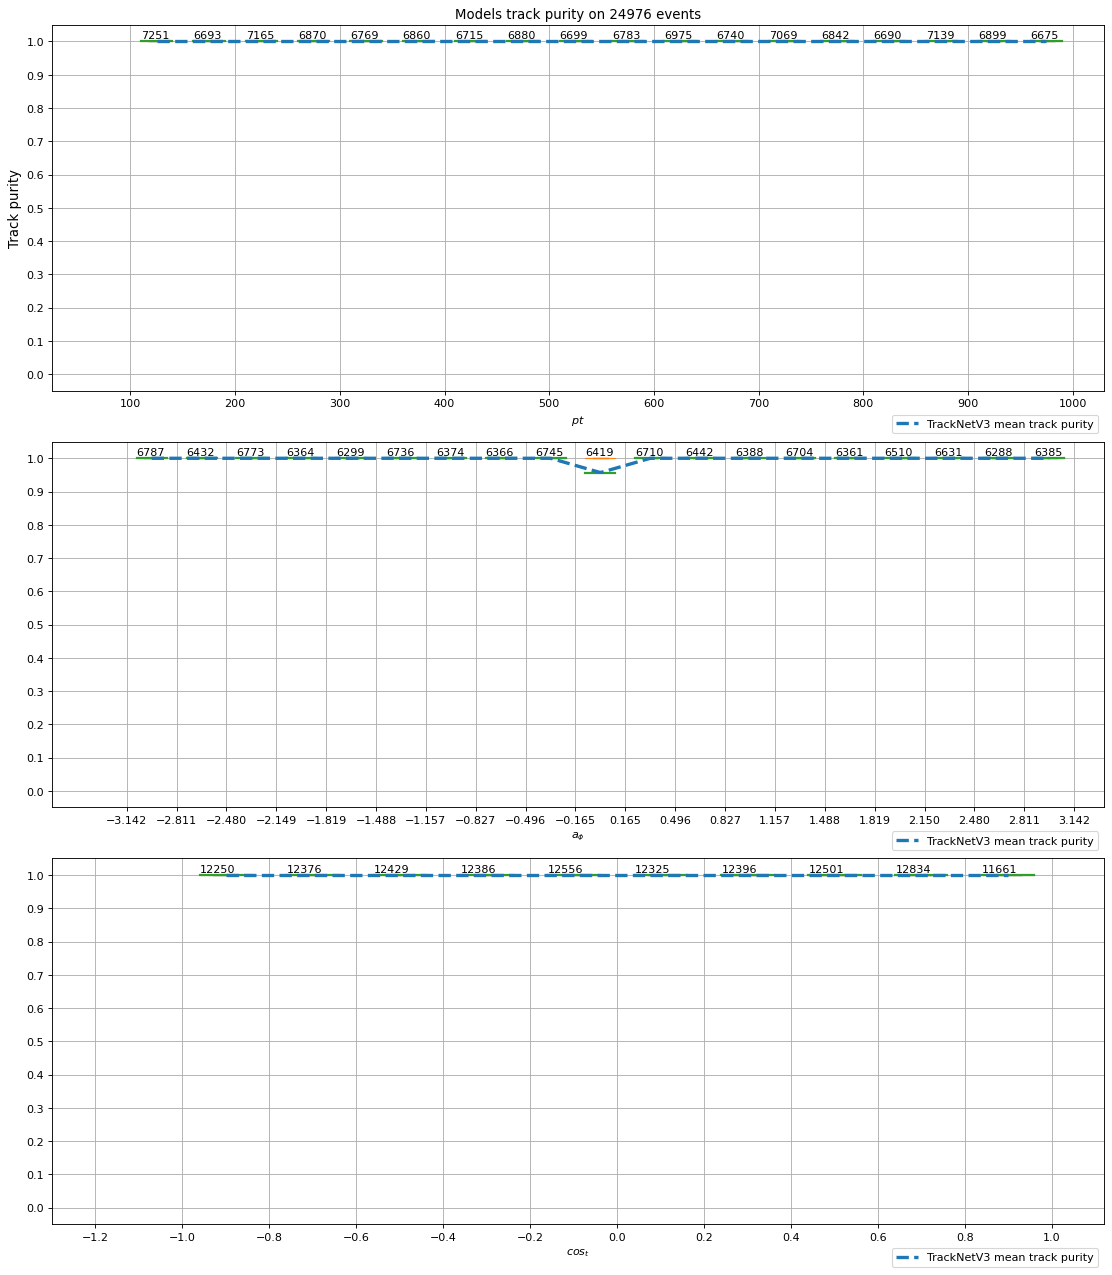

In [88]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_precision)

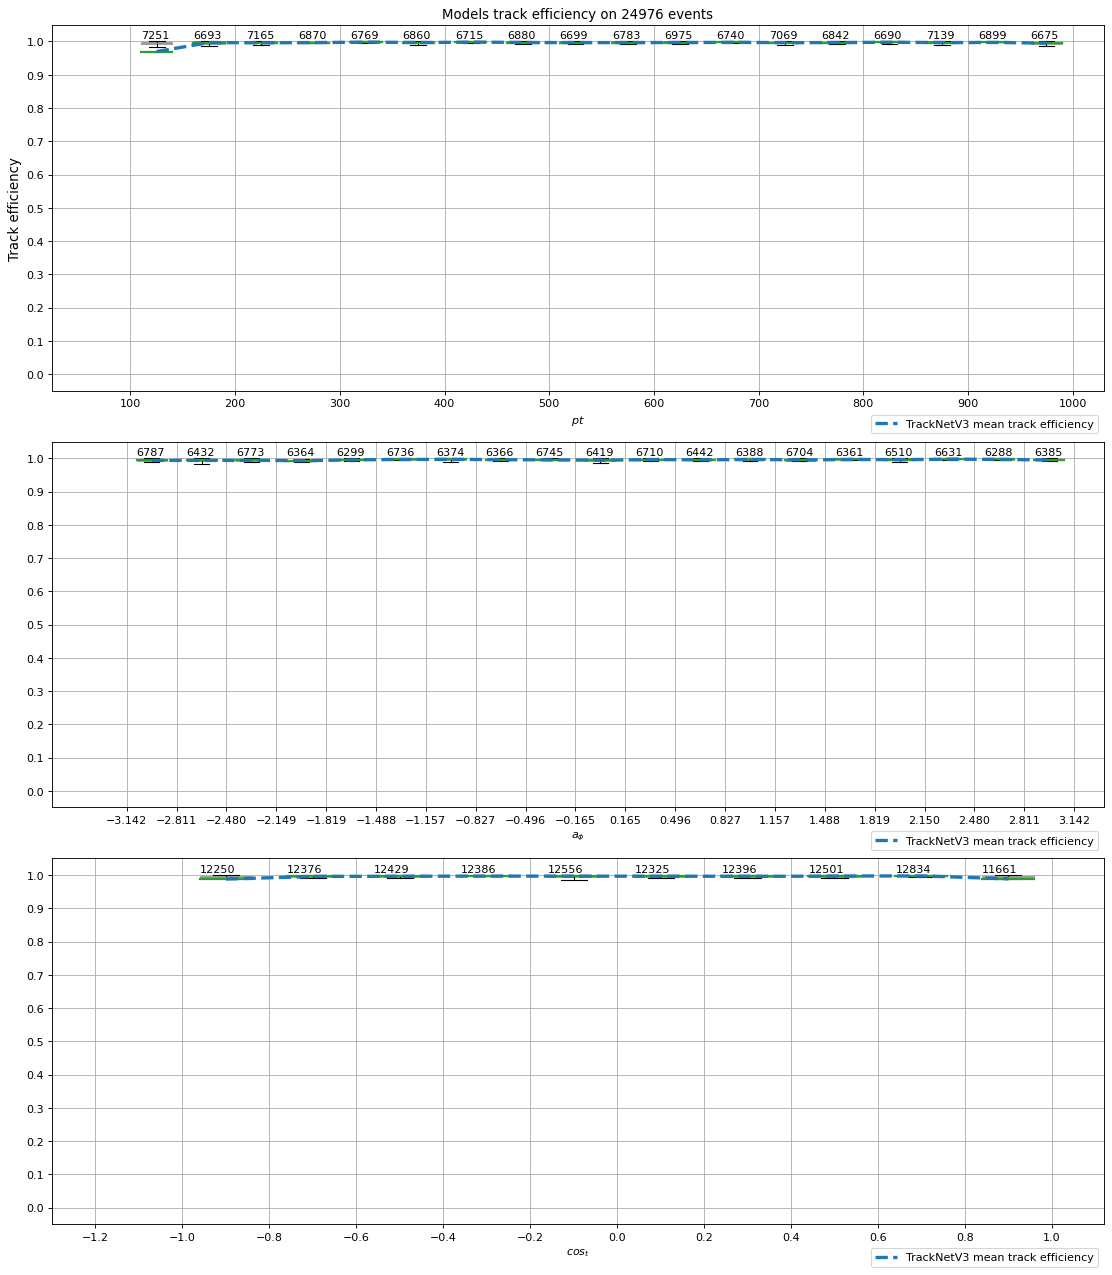

In [83]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_recall)